Evaluate the models

# Stochastic Adversarial Training (StochAT)

## IMPORT LIBRARIES

In [1]:
import numpy as np
import pandas as pd
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import transforms, datasets
from multiprocessing import cpu_count
from collections import OrderedDict
import matplotlib.pyplot as plt
import torch
import olympic

In [2]:
import sys
from typing import Union, Callable, Tuple
sys.path.append('../adversarial/')
sys.path.append('../architectures/')
from functional import boundary, iterated_fgsm, local_search, pgd, entropySmoothing
from ESGD_utils import *

In [3]:
import pickle
import time

In [4]:
import torch.backends.cudnn as cudnn
import argparse, math, random
import ESGD_optim

In [5]:
import time

In [6]:
from trades import trades_loss

In [7]:
if torch.cuda.is_available():
    DEVICE = 'cuda'
else:
    DEVICE = 'cpu'

In [8]:
DEVICE

'cuda'

# LOAD DATA

In [9]:
dataset = 'MNIST' # [MNIST, CIFAR10]
transform = transforms.Compose([
    transforms.ToTensor(),
])
bsz = 128
if dataset == 'MNIST':
    train = datasets.MNIST('../../data/MNIST', train=True, transform=transform, download=True)
    val = datasets.MNIST('../../data/MNIST', train=False, transform=transform, download=True)
elif dataset == 'CIFAR10':
    train = datasets.CIFAR10('../../data/CIFAR10', train=True, transform=transform, download=True)
    val = datasets.CIFAR10('../../data/CIFAR10', train=False, transform=transform, download=True)
    
train_loader = DataLoader(train, batch_size=128, num_workers=cpu_count(),drop_last=True)
val_loader = DataLoader(val, batch_size=128, num_workers=cpu_count(),drop_last=True)

# INITIALIZE NETWORK

In [10]:
if dataset=='MNIST':
    from net_mnist import Net, NetSoft

In [12]:
if dataset=='CIFAR10':
    #[ResNet18,ResNet34,ResNet50,WideResNet]
    from resnet import ResNet18,ResNet34,ResNet50
    from wideresnet import WideResNet
    Net = ResNet18

# RANDOM SEED 

In [13]:
seed = 42
torch.set_num_threads(2)
if DEVICE=='cuda':
    torch.cuda.set_device(-1)
    torch.cuda.manual_seed(seed)
    cudnn.benchmark = True
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# LOAD PRETRAINED OR TRAIN NEW MODELS:

In [14]:
TrainSGD = True
TrainESGD = True
TrainL2 = True
TrainLInf = True
TrainSAT2 = True
TrainSATInf = True
TrainTRADES = True
TrainMART = False
TrainMMA = False

# TRAIN NAIVE MODEL USING SGD

In [15]:
if TrainSGD:
    ## initialize model
    model_SGD = NetSoft().to(DEVICE)
    ## training params
    lr = 0.1
    optimiser = optim.SGD(model_SGD.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    epochs = 10
    ## train model
    history_natural = olympic.fit(
        model_SGD,
        optimiser,
        loss_fn,
        dataloader=train_loader,
        epochs=epochs,
        metrics=['accuracy'],
        prepare_batch = lambda batch: (batch[0].to(DEVICE), batch[1].to(DEVICE)),
        callbacks=[
            olympic.callbacks.Evaluate(val_loader),
            olympic.callbacks.ReduceLROnPlateau(patience=5)
        ]
    )
    ## verify validation accuracy
    print('final validation accuracy:')
    valscore = olympic.evaluate(model_SGD, val_loader, metrics=['accuracy'],
                     prepare_batch = lambda batch: (batch[0].to(DEVICE), batch[1].to(DEVICE)))
    print(valscore)
    ## save model
    modelname = '../trainedmodels/'+dataset+'/SGD_ep'+str(epochs)+'_lr'+str(lr)+'.pt'
    torch.save(model_SGD,modelname)

Epoch 1:   0%|          | 0/468 [00:00<?, ?it/s]

Begin training...


Epoch 10: 100%|██████████| 468/468 [00:02<00:00, 203.35it/s, loss=0.181, accuracy=0.948, val_loss=0.0569, val_accuracy=0.981]

Finished.
final validation accuracy:


{'val_accuracy': 0.981270032051282}


# TRAIN MODEL USING ENTROPY SGD (ESGD)

In [16]:
def entropy_training(model, optimiser, loss_fn, x, y, epoch):
    
    model.train()
    y_pred = model(x)
    
    def helper():
        def feval():
            #x, y = Variable(x), Variable(y.squeeze())
            bsz = x.size(0)
            optimiser.zero_grad()
            yh = model(x)
            f = loss_fn.forward(yh, y)
            f.backward()

            yp = yh.argmax(axis=1)
            prec1 = 100*torch.sum(yp == y)//bsz
            err = 100.-prec1.item()

            return (f.data.item(), err)
        return feval

    loss, err = optimiser.step(helper(), model, loss_fn)
    loss = torch.tensor(loss)
    return loss, y_pred

In [17]:
if TrainESGD:
    ## initialize model
    model_ESGD = NetSoft().to(DEVICE)
    ## training parameters
    lr = 0.1 
    l2 = 0.0 #l2 regularization
    L = 0    #langevin iterations
    gamma = 1e-4 
    scoping = 1e-3
    noise = 1e-4
    loss_fn = nn.CrossEntropyLoss()
    epochs = 5
    optimiser = ESGD_optim.EntropySGD(model_ESGD.parameters(),
            config = dict(lr=lr, momentum=0.9, nesterov=True, weight_decay=l2,
            L=L, eps=noise, g0=gamma, g1=scoping))
    ## train model
    history_natural = olympic.fit(
        model_ESGD,
        optimiser,
        loss_fn,
        dataloader=train_loader,
        epochs=epochs,
        metrics=['accuracy'],
        prepare_batch = lambda batch: (batch[0].to(DEVICE), batch[1].to(DEVICE)),
        update_fn=entropy_training,
        callbacks=[
            olympic.callbacks.Evaluate(val_loader),
            olympic.callbacks.ReduceLROnPlateau(patience=5)
        ]
    )
    ## verify validation accuracy
    print('final validation accuracy:')
    valacc = olympic.evaluate(model_ESGD, val_loader, metrics=['accuracy'],
                         prepare_batch = lambda batch: (batch[0].to(DEVICE), batch[1].to(DEVICE)))
    print(valacc['val_accuracy'])
    ## save trained model
    modelname = '../trainedmodels/'+dataset+'/ESGD_ep'+str(epochs)+'_lr'+str(lr)+'.pt'
    torch.save(model_ESGD,modelname)

Epoch 1:   0%|          | 0/468 [00:00<?, ?it/s]

Begin training...


../adversarial/ESGD_optim.py:98: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  mdw.mul_(mom).add_(1-damp, dw)
Epoch 5: 100%|██████████| 468/468 [00:02<00:00, 165.27it/s, loss=0.279, accuracy=0.92, val_loss=0.0741, val_accuracy=0.979]

Finished.
final validation accuracy:


0.9792668269230769


# TRAIN MODEL USING PGD SGD 

In [18]:
def infnorm(x):
    infn = torch.max(torch.abs(x.detach().cpu()))
    return infn

In [19]:
def adversarial_training(model, optimiser, loss_fn, x, y, epoch, adversary, k, step, eps, norm, random):
    """Performs a single update against a specified adversary"""
    model.train()

    # Adversial perturbation
    x_adv = adversary(model, x, y, loss_fn, k=k, step=step, eps=eps, norm=norm, random=True)
    #print('l2:',torch.norm(x_adv.detach().cpu()-x.detach().cpu())/np.sqrt(x.detach().cpu().size(0)))    
    #print('linf:',infnorm(x_adv.detach().cpu()-x.detach().cpu())/infnorm(x))    

    optimiser.zero_grad()
    y_pred = model(x_adv)
    loss = loss_fn(y_pred, y)
    loss.backward()
    optimiser.step()

    return loss, y_pred

## l2 ball

In [21]:
if TrainL2:
    ## initialize model
    adv_model_l2 = NetSoft().to(DEVICE)
    lr = 0.01
    optimiser = optim.SGD(adv_model_l2.parameters(), lr=lr)
    epochs = 5
    ## train model
    training_history_l2 = olympic.fit(
        adv_model_l2,
        optimiser,
        nn.CrossEntropyLoss(),
        dataloader=train_loader,
        epochs=epochs,
        metrics=['accuracy'],
        prepare_batch = lambda batch: (batch[0].to(DEVICE), batch[1].to(DEVICE)),
        update_fn=adversarial_training,
        update_fn_kwargs={'adversary': pgd, 'k': 2, 'step': 0.05, 'eps': 1.0, 'norm': 2, 'random':True},
        callbacks=[
            olympic.callbacks.Evaluate(val_loader),
            olympic.callbacks.ReduceLROnPlateau(patience=5, factor=0.5, min_delta=0.005, monitor='val_accuracy')
        ]
    )
    ## verify validation accuracy
    print('final validation accuracy:')
    valacc = olympic.evaluate(adv_model_l2, val_loader, metrics=['accuracy'],
                     prepare_batch = lambda batch: (batch[0].to(DEVICE), batch[1].to(DEVICE)))
    print(valacc['val_accuracy'])
    ## save trained model
    modelname = '../trainedmodels/'+dataset+'/AT2_ep'+str(epochs)+'_lr'+str(lr)+'.pt'
    torch.save(adv_model_l2,modelname)

Epoch 1:   0%|          | 0/468 [00:00<?, ?it/s]

Begin training...


Epoch 5: 100%|██████████| 468/468 [00:03<00:00, 121.20it/s, loss=0.585, accuracy=0.82, val_loss=0.253, val_accuracy=0.927]

Finished.
final validation accuracy:


0.9269831730769231


## linf ball

In [22]:
if TrainLInf:
    ## initialize model
    adv_model_linf = NetSoft().to(DEVICE)
    ## train params
    lr = 0.01
    optimiser = optim.SGD(adv_model_linf.parameters(), lr=lr)
    epochs = 5
    ## train model
    training_history_linf = olympic.fit(
        adv_model_linf,
        optimiser,
        nn.CrossEntropyLoss(),
        dataloader=train_loader,
        epochs=epochs,
        metrics=['accuracy'],
        prepare_batch = lambda batch: (batch[0].to(DEVICE), batch[1].to(DEVICE)),
        update_fn=adversarial_training,
        update_fn_kwargs={'adversary': iterated_fgsm,'k': 2, 'step': 0.05, 'eps': 0.1, 'norm': 'inf', 'random':True},
        callbacks=[
            olympic.callbacks.Evaluate(val_loader),
            olympic.callbacks.ReduceLROnPlateau(patience=5, factor=0.5, min_delta=0.005, monitor='val_accuracy')
        ]
    )
    ## verify validation
    print('final validation accuracy:')
    valacc = olympic.evaluate(adv_model_linf, val_loader, metrics=['accuracy'],
                     prepare_batch = lambda batch: (batch[0].to(DEVICE), batch[1].to(DEVICE)))
    
    ## save trained model
    modelname = '../trainedmodels/'+dataset+'/ATInf_ep'+str(epochs)+'_lr'+str(lr)+'.pt'
    torch.save(adv_model_linf,modelname)

Epoch 1:   0%|          | 0/468 [00:00<?, ?it/s]

Begin training...


Epoch 5: 100%|██████████| 468/468 [00:03<00:00, 129.36it/s, loss=0.9, accuracy=0.704, val_loss=0.334, val_accuracy=0.915]

Finished.
final validation accuracy:


# TRAIN MODEL USING SAT

In [23]:
def adversarial_training_entropy(model, optimiser, loss_fn, x, y, epoch, adversary, k, step, eps, norm, gamma):
    """Performs a single update against a specified adversary"""
    model.train()
    
    # Adversial perturbation
    #alpha = 0.8
    N = 1
    loss = 0
    for l in range(N):
        x_adv = adversary(model, x, y, loss_fn, k=k, step=step, eps=eps, norm=norm, random=True, gamma=gamma)
        
        optimiser.zero_grad()
        y_pred = model(x_adv)
        loss = loss + loss_fn(y_pred,y)
        #loss = (1-alpha)*loss + alpha*loss_fn(y_pred, y)
    loss = loss/N
    loss.backward()
    optimiser.step()
    
    return loss, y_pred

In [25]:
if TrainSAT2:
    ## initialize model
    model_SAT2 = NetSoft().to(DEVICE)
    ## train params
    lr = 0.01
    optimiser = optim.SGD(model_SAT2.parameters(), lr=lr)
    epochs = 5
    ## train model
    training_history_entropySmoothing = olympic.fit(
        model_SAT2,
        optimiser,
        nn.CrossEntropyLoss(),
        dataloader=train_loader,
        epochs=epochs,
        metrics=['accuracy'],
        prepare_batch = lambda batch: (batch[0].to(DEVICE), batch[1].to(DEVICE)),
        update_fn=adversarial_training_entropy,
        update_fn_kwargs={'adversary': entropySmoothing, 'k': 2, 'step': 0.05, 'eps': 1.0, 'norm': 2, 'gamma':1e-5},
        callbacks=[
            olympic.callbacks.Evaluate(val_loader),
            olympic.callbacks.ReduceLROnPlateau(patience=5, factor=0.5, min_delta=0.005, monitor='val_accuracy')
        ]
    )
    ## verify validation
    print('final validation accuracy:')
    olympic.evaluate(model_SAT2, val_loader, metrics=['accuracy'],
                     prepare_batch = lambda batch: (batch[0].to(DEVICE), batch[1].to(DEVICE)))
    ## save model
    modelname = '../trainedmodels/'+dataset+'/SAT2_ep'+str(epochs)+'_lr'+str(lr)+'.pt'
    torch.save(model_SAT2,modelname)

Epoch 1:   0%|          | 0/468 [00:00<?, ?it/s]

Begin training...


Epoch 5: 100%|██████████| 468/468 [00:04<00:00, 115.59it/s, loss=0.595, accuracy=0.816, val_loss=0.255, val_accuracy=0.927]

Finished.
final validation accuracy:


In [26]:
if TrainSATInf:
    ## initialize model
    model_SATInf = NetSoft().to(DEVICE)
    ## train params
    lr = 0.01
    optimiser = optim.SGD(model_SATInf.parameters(), lr=lr)
    epochs = 5
    ## train model
    training_history_entropySmoothing = olympic.fit(
        model_SATInf,
        optimiser,
        nn.CrossEntropyLoss(),
        dataloader=train_loader,
        epochs=epochs,
        metrics=['accuracy'],
        prepare_batch = lambda batch: (batch[0].to(DEVICE), batch[1].to(DEVICE)),
        update_fn=adversarial_training_entropy,
        update_fn_kwargs={'adversary': entropySmoothing, 'k': 2, 'step': 0.05, 'eps': 0.1, 'norm': 'inf', 'gamma':1e-5},
        callbacks=[
            olympic.callbacks.Evaluate(val_loader),
            olympic.callbacks.ReduceLROnPlateau(patience=5, factor=0.5, min_delta=0.005, monitor='val_accuracy')
        ]
    )
    ## verify validation
    print('final validation accuracy:')
    olympic.evaluate(model_SATInf, val_loader, metrics=['accuracy'],
                     prepare_batch = lambda batch: (batch[0].to(DEVICE), batch[1].to(DEVICE)))
    ## save model
    modelname = '../trainedmodels/'+dataset+'/SATInf_ep'+str(epochs)+'_lr'+str(lr)+'.pt'
    torch.save(model_SATInf,modelname)

Epoch 1:   0%|          | 0/468 [00:00<?, ?it/s]

Begin training...


Epoch 5: 100%|██████████| 468/468 [00:03<00:00, 122.39it/s, loss=0.637, accuracy=0.801, val_loss=0.264, val_accuracy=0.925]

Finished.
final validation accuracy:


# TRAIN MODEL USING TRADES

In [27]:
args = {}
args['test_batch_size'] = 128
args['no_cuda'] = False
args['epsilon'] = 0.3
args['num_steps'] = 5
args['step_size'] = 0.01
args['random'] =True,
args['model_path']='./checkpoints/model_mnist_smallcnn.pt'
args['source_model_path'] ='./checkpoints/model_mnist_smallcnn.pt'
args['target_model_path'] = './checkpoints/model_mnist_smallcnn.pt'
args['white_box_attack']=True
args['log_interval'] = 100
args['beta'] = 1.0
args['log_interval'] = 1

In [28]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()

        # calculate robust loss
        loss = trades_loss(model=model,
                           x_natural=data,
                           y=target,
                           optimizer=optimizer,
                           step_size=args['step_size'],
                           epsilon=args['epsilon'],
                           perturb_steps=args['num_steps'],
                           beta=args['beta'],
                           distance = 'l_2')
        

        #print('outloss pre step:',loss)
        loss.backward(retain_graph=True)
        
        optimizer.step()
        #print('outloss post step:',loss.item())

        # print progress
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [29]:
def eval_train(model, device, train_loader):
    model.eval()
    train_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            train_loss += F.cross_entropy(output, target, size_average=False).item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    print('Training: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        train_loss, correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))
    training_accuracy = correct / len(train_loader.dataset)
    return train_loss, training_accuracy

In [30]:
def eval_test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, size_average=False).item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print('Test: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_accuracy = correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [31]:
if TrainTRADES:
    ## initialize model
    model_TRADES = Net().to(DEVICE)
    ## training params
    lr = 0.01
    optimizer = optim.SGD(model_TRADES.parameters(), lr=lr)
    epochs = 10
    ## train model

    for epoch in range(1, epochs + 1):
        # adjust learning rate for SGD
        #adjust_learning_rate(optimizer, epoch)

        # adversarial training
        train(args, model_TRADES, DEVICE, train_loader, optimizer, epoch)

        # evaluation on natural examples
        print('================================================================')
        eval_train(model_TRADES, DEVICE, train_loader)
        eval_test(model_TRADES, DEVICE, val_loader)
        print('================================================================')

        
    '''
    history_natural = olympic.fit(
        model_TRADES,
        optimiser,
        nn.KLDivLoss(size_average=False),
        dataloader=train_loader,
        epochs=epochs,
        metrics=['accuracy'],
        prepare_batch = lambda batch: (batch[0].to(DEVICE), batch[1].to(DEVICE)),
        update_fn=trades_obj,
        #update_fn_kwargs={'adversary': entropySmoothing, 'k': 30, 'step': 0.03, 'eps': 0.3, 'norm': 'inf', 'gamma':1e-5},
        callbacks=[
            olympic.callbacks.Evaluate(val_loader),
            olympic.callbacks.ReduceLROnPlateau(patience=5)
        ]
    )
    '''
    ## verify validation accuracy
    #print('final validation accuracy:')
    #valscore = olympic.evaluate(model_TRADES, val_loader, metrics=['accuracy'],
    #                 prepare_batch = lambda batch: (batch[0].to(DEVICE), batch[1].to(DEVICE)))
    ## save model
    modelname = '../trainedmodels/'+dataset+'/TRADES_ep'+str(epochs)+'_lr'+str(lr)+'.pt'
    torch.save(model_TRADES,modelname)

/home/gauri/.local/lib/python3.8/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.306984
Train Epoch: 1 [128/60000 (0%)]	Loss: 2.296862
Train Epoch: 1 [256/60000 (0%)]	Loss: 2.301613
Train Epoch: 1 [384/60000 (1%)]	Loss: 2.299722
Train Epoch: 1 [512/60000 (1%)]	Loss: 2.315302
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.305764
Train Epoch: 1 [768/60000 (1%)]	Loss: 2.306420
Train Epoch: 1 [896/60000 (1%)]	Loss: 2.314331
Train Epoch: 1 [1024/60000 (2%)]	Loss: 2.311337
Train Epoch: 1 [1152/60000 (2%)]	Loss: 2.294602
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.305999
Train Epoch: 1 [1408/60000 (2%)]	Loss: 2.312844
Train Epoch: 1 [1536/60000 (3%)]	Loss: 2.291073
Train Epoch: 1 [1664/60000 (3%)]	Loss: 2.304793
Train Epoch: 1 [1792/60000 (3%)]	Loss: 2.310278
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.301413
Train Epoch: 1 [2048/60000 (3%)]	Loss: 2.304006
Train Epoch: 1 [2176/60000 (4%)]	Loss: 2.300539
Train Epoch: 1 [2304/60000 (4%)]	Loss: 2.302885
Train Epoch: 1 [2432/60000 (4%)]	Loss: 2.302083
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.295130
Tr

Train Epoch: 1 [22656/60000 (38%)]	Loss: 2.280075
Train Epoch: 1 [22784/60000 (38%)]	Loss: 2.292664
Train Epoch: 1 [22912/60000 (38%)]	Loss: 2.275429
Train Epoch: 1 [23040/60000 (38%)]	Loss: 2.279511
Train Epoch: 1 [23168/60000 (39%)]	Loss: 2.284936
Train Epoch: 1 [23296/60000 (39%)]	Loss: 2.271880
Train Epoch: 1 [23424/60000 (39%)]	Loss: 2.283242
Train Epoch: 1 [23552/60000 (39%)]	Loss: 2.283988
Train Epoch: 1 [23680/60000 (40%)]	Loss: 2.280494
Train Epoch: 1 [23808/60000 (40%)]	Loss: 2.280482
Train Epoch: 1 [23936/60000 (40%)]	Loss: 2.282231
Train Epoch: 1 [24064/60000 (40%)]	Loss: 2.274110
Train Epoch: 1 [24192/60000 (40%)]	Loss: 2.277295
Train Epoch: 1 [24320/60000 (41%)]	Loss: 2.283407
Train Epoch: 1 [24448/60000 (41%)]	Loss: 2.272648
Train Epoch: 1 [24576/60000 (41%)]	Loss: 2.277533
Train Epoch: 1 [24704/60000 (41%)]	Loss: 2.280505
Train Epoch: 1 [24832/60000 (41%)]	Loss: 2.287986
Train Epoch: 1 [24960/60000 (42%)]	Loss: 2.273162
Train Epoch: 1 [25088/60000 (42%)]	Loss: 2.280904


Train Epoch: 1 [44672/60000 (75%)]	Loss: 2.224964
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.238142
Train Epoch: 1 [44928/60000 (75%)]	Loss: 2.231721
Train Epoch: 1 [45056/60000 (75%)]	Loss: 2.225406
Train Epoch: 1 [45184/60000 (75%)]	Loss: 2.223253
Train Epoch: 1 [45312/60000 (76%)]	Loss: 2.219129
Train Epoch: 1 [45440/60000 (76%)]	Loss: 2.220951
Train Epoch: 1 [45568/60000 (76%)]	Loss: 2.208453
Train Epoch: 1 [45696/60000 (76%)]	Loss: 2.211915
Train Epoch: 1 [45824/60000 (76%)]	Loss: 2.247065
Train Epoch: 1 [45952/60000 (77%)]	Loss: 2.218020
Train Epoch: 1 [46080/60000 (77%)]	Loss: 2.228865
Train Epoch: 1 [46208/60000 (77%)]	Loss: 2.245008
Train Epoch: 1 [46336/60000 (77%)]	Loss: 2.217327
Train Epoch: 1 [46464/60000 (78%)]	Loss: 2.208501
Train Epoch: 1 [46592/60000 (78%)]	Loss: 2.210084
Train Epoch: 1 [46720/60000 (78%)]	Loss: 2.235343
Train Epoch: 1 [46848/60000 (78%)]	Loss: 2.215467
Train Epoch: 1 [46976/60000 (78%)]	Loss: 2.227422
Train Epoch: 1 [47104/60000 (79%)]	Loss: 2.201626


Train Epoch: 2 [6144/60000 (10%)]	Loss: 2.117373
Train Epoch: 2 [6272/60000 (10%)]	Loss: 2.127830
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.099058
Train Epoch: 2 [6528/60000 (11%)]	Loss: 2.044782
Train Epoch: 2 [6656/60000 (11%)]	Loss: 2.057832
Train Epoch: 2 [6784/60000 (11%)]	Loss: 2.145565
Train Epoch: 2 [6912/60000 (12%)]	Loss: 2.049542
Train Epoch: 2 [7040/60000 (12%)]	Loss: 2.091748
Train Epoch: 2 [7168/60000 (12%)]	Loss: 2.119197
Train Epoch: 2 [7296/60000 (12%)]	Loss: 2.121116
Train Epoch: 2 [7424/60000 (12%)]	Loss: 2.118136
Train Epoch: 2 [7552/60000 (13%)]	Loss: 2.107317
Train Epoch: 2 [7680/60000 (13%)]	Loss: 2.107777
Train Epoch: 2 [7808/60000 (13%)]	Loss: 2.048890
Train Epoch: 2 [7936/60000 (13%)]	Loss: 2.030258
Train Epoch: 2 [8064/60000 (13%)]	Loss: 2.062024
Train Epoch: 2 [8192/60000 (14%)]	Loss: 2.069755
Train Epoch: 2 [8320/60000 (14%)]	Loss: 2.097136
Train Epoch: 2 [8448/60000 (14%)]	Loss: 2.053003
Train Epoch: 2 [8576/60000 (14%)]	Loss: 2.101554
Train Epoch: 2 [8704

Train Epoch: 2 [28672/60000 (48%)]	Loss: 1.830768
Train Epoch: 2 [28800/60000 (48%)]	Loss: 1.783298
Train Epoch: 2 [28928/60000 (48%)]	Loss: 1.905145
Train Epoch: 2 [29056/60000 (49%)]	Loss: 1.922223
Train Epoch: 2 [29184/60000 (49%)]	Loss: 1.750807
Train Epoch: 2 [29312/60000 (49%)]	Loss: 1.770967
Train Epoch: 2 [29440/60000 (49%)]	Loss: 1.729061
Train Epoch: 2 [29568/60000 (49%)]	Loss: 1.770158
Train Epoch: 2 [29696/60000 (50%)]	Loss: 1.884751
Train Epoch: 2 [29824/60000 (50%)]	Loss: 1.909884
Train Epoch: 2 [29952/60000 (50%)]	Loss: 1.858840
Train Epoch: 2 [30080/60000 (50%)]	Loss: 1.958355
Train Epoch: 2 [30208/60000 (50%)]	Loss: 1.735425
Train Epoch: 2 [30336/60000 (51%)]	Loss: 1.838262
Train Epoch: 2 [30464/60000 (51%)]	Loss: 1.913623
Train Epoch: 2 [30592/60000 (51%)]	Loss: 1.837665
Train Epoch: 2 [30720/60000 (51%)]	Loss: 1.843752
Train Epoch: 2 [30848/60000 (51%)]	Loss: 1.802750
Train Epoch: 2 [30976/60000 (52%)]	Loss: 1.816552
Train Epoch: 2 [31104/60000 (52%)]	Loss: 1.746221


Train Epoch: 2 [51072/60000 (85%)]	Loss: 1.589620
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.619777
Train Epoch: 2 [51328/60000 (86%)]	Loss: 1.581535
Train Epoch: 2 [51456/60000 (86%)]	Loss: 1.492258
Train Epoch: 2 [51584/60000 (86%)]	Loss: 1.552118
Train Epoch: 2 [51712/60000 (86%)]	Loss: 1.644328
Train Epoch: 2 [51840/60000 (87%)]	Loss: 1.713613
Train Epoch: 2 [51968/60000 (87%)]	Loss: 1.652043
Train Epoch: 2 [52096/60000 (87%)]	Loss: 1.700860
Train Epoch: 2 [52224/60000 (87%)]	Loss: 1.572742
Train Epoch: 2 [52352/60000 (87%)]	Loss: 1.544599
Train Epoch: 2 [52480/60000 (88%)]	Loss: 1.462863
Train Epoch: 2 [52608/60000 (88%)]	Loss: 1.636984
Train Epoch: 2 [52736/60000 (88%)]	Loss: 1.727044
Train Epoch: 2 [52864/60000 (88%)]	Loss: 1.586764
Train Epoch: 2 [52992/60000 (88%)]	Loss: 1.562785
Train Epoch: 2 [53120/60000 (89%)]	Loss: 1.603533
Train Epoch: 2 [53248/60000 (89%)]	Loss: 1.489451
Train Epoch: 2 [53376/60000 (89%)]	Loss: 1.498428
Train Epoch: 2 [53504/60000 (89%)]	Loss: 1.686831


Train Epoch: 3 [13184/60000 (22%)]	Loss: 1.402325
Train Epoch: 3 [13312/60000 (22%)]	Loss: 1.498176
Train Epoch: 3 [13440/60000 (22%)]	Loss: 1.334030
Train Epoch: 3 [13568/60000 (23%)]	Loss: 1.481858
Train Epoch: 3 [13696/60000 (23%)]	Loss: 1.425492
Train Epoch: 3 [13824/60000 (23%)]	Loss: 1.548652
Train Epoch: 3 [13952/60000 (23%)]	Loss: 1.593307
Train Epoch: 3 [14080/60000 (24%)]	Loss: 1.413580
Train Epoch: 3 [14208/60000 (24%)]	Loss: 1.612691
Train Epoch: 3 [14336/60000 (24%)]	Loss: 1.503004
Train Epoch: 3 [14464/60000 (24%)]	Loss: 1.505240
Train Epoch: 3 [14592/60000 (24%)]	Loss: 1.543779
Train Epoch: 3 [14720/60000 (25%)]	Loss: 1.572675
Train Epoch: 3 [14848/60000 (25%)]	Loss: 1.438109
Train Epoch: 3 [14976/60000 (25%)]	Loss: 1.332200
Train Epoch: 3 [15104/60000 (25%)]	Loss: 1.500387
Train Epoch: 3 [15232/60000 (25%)]	Loss: 1.461321
Train Epoch: 3 [15360/60000 (26%)]	Loss: 1.403428
Train Epoch: 3 [15488/60000 (26%)]	Loss: 1.351022
Train Epoch: 3 [15616/60000 (26%)]	Loss: 1.486539


Train Epoch: 3 [34304/60000 (57%)]	Loss: 1.400682
Train Epoch: 3 [34432/60000 (57%)]	Loss: 1.356450
Train Epoch: 3 [34560/60000 (58%)]	Loss: 1.462356
Train Epoch: 3 [34688/60000 (58%)]	Loss: 1.555747
Train Epoch: 3 [34816/60000 (58%)]	Loss: 1.479523
Train Epoch: 3 [34944/60000 (58%)]	Loss: 1.300501
Train Epoch: 3 [35072/60000 (59%)]	Loss: 1.394978
Train Epoch: 3 [35200/60000 (59%)]	Loss: 1.407902
Train Epoch: 3 [35328/60000 (59%)]	Loss: 1.305326
Train Epoch: 3 [35456/60000 (59%)]	Loss: 1.352494
Train Epoch: 3 [35584/60000 (59%)]	Loss: 1.394271
Train Epoch: 3 [35712/60000 (60%)]	Loss: 1.205280
Train Epoch: 3 [35840/60000 (60%)]	Loss: 1.258844
Train Epoch: 3 [35968/60000 (60%)]	Loss: 1.456295
Train Epoch: 3 [36096/60000 (60%)]	Loss: 1.319268
Train Epoch: 3 [36224/60000 (60%)]	Loss: 1.256676
Train Epoch: 3 [36352/60000 (61%)]	Loss: 1.357022
Train Epoch: 3 [36480/60000 (61%)]	Loss: 1.287446
Train Epoch: 3 [36608/60000 (61%)]	Loss: 1.253179
Train Epoch: 3 [36736/60000 (61%)]	Loss: 1.283235


Train Epoch: 3 [56448/60000 (94%)]	Loss: 1.310464
Train Epoch: 3 [56576/60000 (94%)]	Loss: 1.335332
Train Epoch: 3 [56704/60000 (95%)]	Loss: 1.169059
Train Epoch: 3 [56832/60000 (95%)]	Loss: 1.193006
Train Epoch: 3 [56960/60000 (95%)]	Loss: 1.278722
Train Epoch: 3 [57088/60000 (95%)]	Loss: 1.240184
Train Epoch: 3 [57216/60000 (96%)]	Loss: 1.482271
Train Epoch: 3 [57344/60000 (96%)]	Loss: 1.231536
Train Epoch: 3 [57472/60000 (96%)]	Loss: 1.139239
Train Epoch: 3 [57600/60000 (96%)]	Loss: 1.426372
Train Epoch: 3 [57728/60000 (96%)]	Loss: 1.376134
Train Epoch: 3 [57856/60000 (97%)]	Loss: 1.162246
Train Epoch: 3 [57984/60000 (97%)]	Loss: 1.242147
Train Epoch: 3 [58112/60000 (97%)]	Loss: 1.054925
Train Epoch: 3 [58240/60000 (97%)]	Loss: 1.056360
Train Epoch: 3 [58368/60000 (97%)]	Loss: 1.191705
Train Epoch: 3 [58496/60000 (98%)]	Loss: 1.085744
Train Epoch: 3 [58624/60000 (98%)]	Loss: 1.119882
Train Epoch: 3 [58752/60000 (98%)]	Loss: 1.273721
Train Epoch: 3 [58880/60000 (98%)]	Loss: 1.020870


Train Epoch: 4 [17920/60000 (30%)]	Loss: 1.207654
Train Epoch: 4 [18048/60000 (30%)]	Loss: 1.132084
Train Epoch: 4 [18176/60000 (30%)]	Loss: 1.096261
Train Epoch: 4 [18304/60000 (31%)]	Loss: 1.268672
Train Epoch: 4 [18432/60000 (31%)]	Loss: 1.197523
Train Epoch: 4 [18560/60000 (31%)]	Loss: 1.302903
Train Epoch: 4 [18688/60000 (31%)]	Loss: 1.152578
Train Epoch: 4 [18816/60000 (31%)]	Loss: 1.170304
Train Epoch: 4 [18944/60000 (32%)]	Loss: 1.306533
Train Epoch: 4 [19072/60000 (32%)]	Loss: 1.338907
Train Epoch: 4 [19200/60000 (32%)]	Loss: 1.180876
Train Epoch: 4 [19328/60000 (32%)]	Loss: 1.314431
Train Epoch: 4 [19456/60000 (32%)]	Loss: 1.279646
Train Epoch: 4 [19584/60000 (33%)]	Loss: 1.093232
Train Epoch: 4 [19712/60000 (33%)]	Loss: 1.011479
Train Epoch: 4 [19840/60000 (33%)]	Loss: 1.249761
Train Epoch: 4 [19968/60000 (33%)]	Loss: 1.309470
Train Epoch: 4 [20096/60000 (34%)]	Loss: 1.406680
Train Epoch: 4 [20224/60000 (34%)]	Loss: 1.209715
Train Epoch: 4 [20352/60000 (34%)]	Loss: 1.112756


Train Epoch: 4 [39424/60000 (66%)]	Loss: 1.295762
Train Epoch: 4 [39552/60000 (66%)]	Loss: 1.080608
Train Epoch: 4 [39680/60000 (66%)]	Loss: 1.252315
Train Epoch: 4 [39808/60000 (66%)]	Loss: 1.233636
Train Epoch: 4 [39936/60000 (67%)]	Loss: 1.105808
Train Epoch: 4 [40064/60000 (67%)]	Loss: 1.116897
Train Epoch: 4 [40192/60000 (67%)]	Loss: 1.185127
Train Epoch: 4 [40320/60000 (67%)]	Loss: 1.067316
Train Epoch: 4 [40448/60000 (68%)]	Loss: 1.218182
Train Epoch: 4 [40576/60000 (68%)]	Loss: 1.160460
Train Epoch: 4 [40704/60000 (68%)]	Loss: 1.129543
Train Epoch: 4 [40832/60000 (68%)]	Loss: 0.940666
Train Epoch: 4 [40960/60000 (68%)]	Loss: 1.215525
Train Epoch: 4 [41088/60000 (69%)]	Loss: 1.107597
Train Epoch: 4 [41216/60000 (69%)]	Loss: 1.467473
Train Epoch: 4 [41344/60000 (69%)]	Loss: 1.334416
Train Epoch: 4 [41472/60000 (69%)]	Loss: 1.375512
Train Epoch: 4 [41600/60000 (69%)]	Loss: 1.058829
Train Epoch: 4 [41728/60000 (70%)]	Loss: 1.084842
Train Epoch: 4 [41856/60000 (70%)]	Loss: 1.140875


Train Epoch: 5 [0/60000 (0%)]	Loss: 1.155546
Train Epoch: 5 [128/60000 (0%)]	Loss: 1.162005
Train Epoch: 5 [256/60000 (0%)]	Loss: 1.050108
Train Epoch: 5 [384/60000 (1%)]	Loss: 1.094493
Train Epoch: 5 [512/60000 (1%)]	Loss: 1.209744
Train Epoch: 5 [640/60000 (1%)]	Loss: 0.950250
Train Epoch: 5 [768/60000 (1%)]	Loss: 1.294509
Train Epoch: 5 [896/60000 (1%)]	Loss: 1.182575
Train Epoch: 5 [1024/60000 (2%)]	Loss: 1.350753
Train Epoch: 5 [1152/60000 (2%)]	Loss: 1.092785
Train Epoch: 5 [1280/60000 (2%)]	Loss: 1.167883
Train Epoch: 5 [1408/60000 (2%)]	Loss: 1.158268
Train Epoch: 5 [1536/60000 (3%)]	Loss: 1.122755
Train Epoch: 5 [1664/60000 (3%)]	Loss: 1.130487
Train Epoch: 5 [1792/60000 (3%)]	Loss: 0.968398
Train Epoch: 5 [1920/60000 (3%)]	Loss: 1.131233
Train Epoch: 5 [2048/60000 (3%)]	Loss: 0.981224
Train Epoch: 5 [2176/60000 (4%)]	Loss: 0.985499
Train Epoch: 5 [2304/60000 (4%)]	Loss: 1.046505
Train Epoch: 5 [2432/60000 (4%)]	Loss: 1.098275
Train Epoch: 5 [2560/60000 (4%)]	Loss: 1.080137
Tr

Train Epoch: 5 [22400/60000 (37%)]	Loss: 1.278522
Train Epoch: 5 [22528/60000 (38%)]	Loss: 1.278320
Train Epoch: 5 [22656/60000 (38%)]	Loss: 1.064486
Train Epoch: 5 [22784/60000 (38%)]	Loss: 1.014677
Train Epoch: 5 [22912/60000 (38%)]	Loss: 1.058283
Train Epoch: 5 [23040/60000 (38%)]	Loss: 1.075641
Train Epoch: 5 [23168/60000 (39%)]	Loss: 1.033353
Train Epoch: 5 [23296/60000 (39%)]	Loss: 0.951113
Train Epoch: 5 [23424/60000 (39%)]	Loss: 1.169116
Train Epoch: 5 [23552/60000 (39%)]	Loss: 1.114299
Train Epoch: 5 [23680/60000 (40%)]	Loss: 1.220328
Train Epoch: 5 [23808/60000 (40%)]	Loss: 1.090182
Train Epoch: 5 [23936/60000 (40%)]	Loss: 1.120238
Train Epoch: 5 [24064/60000 (40%)]	Loss: 1.085670
Train Epoch: 5 [24192/60000 (40%)]	Loss: 1.257832
Train Epoch: 5 [24320/60000 (41%)]	Loss: 0.980685
Train Epoch: 5 [24448/60000 (41%)]	Loss: 1.035411
Train Epoch: 5 [24576/60000 (41%)]	Loss: 1.175304
Train Epoch: 5 [24704/60000 (41%)]	Loss: 1.388878
Train Epoch: 5 [24832/60000 (41%)]	Loss: 1.105511


Train Epoch: 5 [43904/60000 (73%)]	Loss: 1.072506
Train Epoch: 5 [44032/60000 (74%)]	Loss: 1.055745
Train Epoch: 5 [44160/60000 (74%)]	Loss: 1.154040
Train Epoch: 5 [44288/60000 (74%)]	Loss: 0.976083
Train Epoch: 5 [44416/60000 (74%)]	Loss: 0.984970
Train Epoch: 5 [44544/60000 (74%)]	Loss: 0.848503
Train Epoch: 5 [44672/60000 (75%)]	Loss: 1.083702
Train Epoch: 5 [44800/60000 (75%)]	Loss: 1.236695
Train Epoch: 5 [44928/60000 (75%)]	Loss: 1.340373
Train Epoch: 5 [45056/60000 (75%)]	Loss: 1.195528
Train Epoch: 5 [45184/60000 (75%)]	Loss: 0.997245
Train Epoch: 5 [45312/60000 (76%)]	Loss: 0.928168
Train Epoch: 5 [45440/60000 (76%)]	Loss: 1.094852
Train Epoch: 5 [45568/60000 (76%)]	Loss: 1.078899
Train Epoch: 5 [45696/60000 (76%)]	Loss: 1.050313
Train Epoch: 5 [45824/60000 (76%)]	Loss: 1.163037
Train Epoch: 5 [45952/60000 (77%)]	Loss: 1.092577
Train Epoch: 5 [46080/60000 (77%)]	Loss: 1.070331
Train Epoch: 5 [46208/60000 (77%)]	Loss: 1.203439
Train Epoch: 5 [46336/60000 (77%)]	Loss: 1.168298


Train Epoch: 6 [5888/60000 (10%)]	Loss: 0.972645
Train Epoch: 6 [6016/60000 (10%)]	Loss: 0.708781
Train Epoch: 6 [6144/60000 (10%)]	Loss: 1.200084
Train Epoch: 6 [6272/60000 (10%)]	Loss: 1.017487
Train Epoch: 6 [6400/60000 (11%)]	Loss: 1.037846
Train Epoch: 6 [6528/60000 (11%)]	Loss: 0.931494
Train Epoch: 6 [6656/60000 (11%)]	Loss: 1.003819
Train Epoch: 6 [6784/60000 (11%)]	Loss: 1.101857
Train Epoch: 6 [6912/60000 (12%)]	Loss: 1.136886
Train Epoch: 6 [7040/60000 (12%)]	Loss: 1.079861
Train Epoch: 6 [7168/60000 (12%)]	Loss: 1.218195
Train Epoch: 6 [7296/60000 (12%)]	Loss: 1.226914
Train Epoch: 6 [7424/60000 (12%)]	Loss: 0.998770
Train Epoch: 6 [7552/60000 (13%)]	Loss: 1.135073
Train Epoch: 6 [7680/60000 (13%)]	Loss: 1.013658
Train Epoch: 6 [7808/60000 (13%)]	Loss: 1.143670
Train Epoch: 6 [7936/60000 (13%)]	Loss: 0.993368
Train Epoch: 6 [8064/60000 (13%)]	Loss: 1.096491
Train Epoch: 6 [8192/60000 (14%)]	Loss: 1.140323
Train Epoch: 6 [8320/60000 (14%)]	Loss: 1.042244
Train Epoch: 6 [8448

Train Epoch: 6 [27904/60000 (47%)]	Loss: 0.728790
Train Epoch: 6 [28032/60000 (47%)]	Loss: 0.774599
Train Epoch: 6 [28160/60000 (47%)]	Loss: 0.889719
Train Epoch: 6 [28288/60000 (47%)]	Loss: 1.138283
Train Epoch: 6 [28416/60000 (47%)]	Loss: 1.085405
Train Epoch: 6 [28544/60000 (48%)]	Loss: 1.047590
Train Epoch: 6 [28672/60000 (48%)]	Loss: 1.077568
Train Epoch: 6 [28800/60000 (48%)]	Loss: 1.112333
Train Epoch: 6 [28928/60000 (48%)]	Loss: 1.139118
Train Epoch: 6 [29056/60000 (49%)]	Loss: 1.212244
Train Epoch: 6 [29184/60000 (49%)]	Loss: 1.018209
Train Epoch: 6 [29312/60000 (49%)]	Loss: 0.990133
Train Epoch: 6 [29440/60000 (49%)]	Loss: 0.953828
Train Epoch: 6 [29568/60000 (49%)]	Loss: 1.116565
Train Epoch: 6 [29696/60000 (50%)]	Loss: 1.114839
Train Epoch: 6 [29824/60000 (50%)]	Loss: 1.183293
Train Epoch: 6 [29952/60000 (50%)]	Loss: 1.014659
Train Epoch: 6 [30080/60000 (50%)]	Loss: 1.085425
Train Epoch: 6 [30208/60000 (50%)]	Loss: 1.050519
Train Epoch: 6 [30336/60000 (51%)]	Loss: 0.996686


Train Epoch: 6 [50048/60000 (84%)]	Loss: 0.983054
Train Epoch: 6 [50176/60000 (84%)]	Loss: 1.095457
Train Epoch: 6 [50304/60000 (84%)]	Loss: 1.314433
Train Epoch: 6 [50432/60000 (84%)]	Loss: 0.886040
Train Epoch: 6 [50560/60000 (84%)]	Loss: 0.930886
Train Epoch: 6 [50688/60000 (85%)]	Loss: 1.105791
Train Epoch: 6 [50816/60000 (85%)]	Loss: 0.986536
Train Epoch: 6 [50944/60000 (85%)]	Loss: 0.784054
Train Epoch: 6 [51072/60000 (85%)]	Loss: 1.000374
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.966970
Train Epoch: 6 [51328/60000 (86%)]	Loss: 0.865810
Train Epoch: 6 [51456/60000 (86%)]	Loss: 0.820168
Train Epoch: 6 [51584/60000 (86%)]	Loss: 0.828324
Train Epoch: 6 [51712/60000 (86%)]	Loss: 0.976310
Train Epoch: 6 [51840/60000 (87%)]	Loss: 1.023046
Train Epoch: 6 [51968/60000 (87%)]	Loss: 1.014522
Train Epoch: 6 [52096/60000 (87%)]	Loss: 1.170366
Train Epoch: 6 [52224/60000 (87%)]	Loss: 1.030451
Train Epoch: 6 [52352/60000 (87%)]	Loss: 0.836690
Train Epoch: 6 [52480/60000 (88%)]	Loss: 0.840179


Train Epoch: 7 [12160/60000 (20%)]	Loss: 1.056501
Train Epoch: 7 [12288/60000 (21%)]	Loss: 0.935750
Train Epoch: 7 [12416/60000 (21%)]	Loss: 1.026054
Train Epoch: 7 [12544/60000 (21%)]	Loss: 1.049823
Train Epoch: 7 [12672/60000 (21%)]	Loss: 1.035064
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.954225
Train Epoch: 7 [12928/60000 (22%)]	Loss: 1.285213
Train Epoch: 7 [13056/60000 (22%)]	Loss: 1.251214
Train Epoch: 7 [13184/60000 (22%)]	Loss: 0.831344
Train Epoch: 7 [13312/60000 (22%)]	Loss: 0.942763
Train Epoch: 7 [13440/60000 (22%)]	Loss: 0.877714
Train Epoch: 7 [13568/60000 (23%)]	Loss: 0.963017
Train Epoch: 7 [13696/60000 (23%)]	Loss: 1.058520
Train Epoch: 7 [13824/60000 (23%)]	Loss: 0.973518
Train Epoch: 7 [13952/60000 (23%)]	Loss: 1.149018
Train Epoch: 7 [14080/60000 (24%)]	Loss: 0.995420
Train Epoch: 7 [14208/60000 (24%)]	Loss: 1.222093
Train Epoch: 7 [14336/60000 (24%)]	Loss: 1.103558
Train Epoch: 7 [14464/60000 (24%)]	Loss: 0.958845
Train Epoch: 7 [14592/60000 (24%)]	Loss: 1.237271


Train Epoch: 7 [33408/60000 (56%)]	Loss: 0.881964
Train Epoch: 7 [33536/60000 (56%)]	Loss: 0.979513
Train Epoch: 7 [33664/60000 (56%)]	Loss: 0.907996
Train Epoch: 7 [33792/60000 (56%)]	Loss: 0.814556
Train Epoch: 7 [33920/60000 (57%)]	Loss: 0.856154
Train Epoch: 7 [34048/60000 (57%)]	Loss: 0.928254
Train Epoch: 7 [34176/60000 (57%)]	Loss: 0.895606
Train Epoch: 7 [34304/60000 (57%)]	Loss: 0.966213
Train Epoch: 7 [34432/60000 (57%)]	Loss: 0.973540
Train Epoch: 7 [34560/60000 (58%)]	Loss: 0.945185
Train Epoch: 7 [34688/60000 (58%)]	Loss: 1.186849
Train Epoch: 7 [34816/60000 (58%)]	Loss: 1.124424
Train Epoch: 7 [34944/60000 (58%)]	Loss: 0.847198
Train Epoch: 7 [35072/60000 (59%)]	Loss: 0.963100
Train Epoch: 7 [35200/60000 (59%)]	Loss: 0.919775
Train Epoch: 7 [35328/60000 (59%)]	Loss: 0.746177
Train Epoch: 7 [35456/60000 (59%)]	Loss: 0.920852
Train Epoch: 7 [35584/60000 (59%)]	Loss: 1.063922
Train Epoch: 7 [35712/60000 (60%)]	Loss: 0.730636
Train Epoch: 7 [35840/60000 (60%)]	Loss: 1.025966


Train Epoch: 7 [55168/60000 (92%)]	Loss: 0.889496
Train Epoch: 7 [55296/60000 (92%)]	Loss: 0.736112
Train Epoch: 7 [55424/60000 (93%)]	Loss: 0.807903
Train Epoch: 7 [55552/60000 (93%)]	Loss: 0.765822
Train Epoch: 7 [55680/60000 (93%)]	Loss: 0.910263
Train Epoch: 7 [55808/60000 (93%)]	Loss: 0.809923
Train Epoch: 7 [55936/60000 (93%)]	Loss: 0.767853
Train Epoch: 7 [56064/60000 (94%)]	Loss: 0.789289
Train Epoch: 7 [56192/60000 (94%)]	Loss: 1.009079
Train Epoch: 7 [56320/60000 (94%)]	Loss: 0.838690
Train Epoch: 7 [56448/60000 (94%)]	Loss: 0.899032
Train Epoch: 7 [56576/60000 (94%)]	Loss: 0.871050
Train Epoch: 7 [56704/60000 (95%)]	Loss: 0.713182
Train Epoch: 7 [56832/60000 (95%)]	Loss: 0.866816
Train Epoch: 7 [56960/60000 (95%)]	Loss: 0.919812
Train Epoch: 7 [57088/60000 (95%)]	Loss: 0.801498
Train Epoch: 7 [57216/60000 (96%)]	Loss: 1.078270
Train Epoch: 7 [57344/60000 (96%)]	Loss: 0.890282
Train Epoch: 7 [57472/60000 (96%)]	Loss: 1.000520
Train Epoch: 7 [57600/60000 (96%)]	Loss: 1.033701


Train Epoch: 8 [17024/60000 (28%)]	Loss: 0.931447
Train Epoch: 8 [17152/60000 (29%)]	Loss: 0.994390
Train Epoch: 8 [17280/60000 (29%)]	Loss: 0.877683
Train Epoch: 8 [17408/60000 (29%)]	Loss: 1.000554
Train Epoch: 8 [17536/60000 (29%)]	Loss: 1.129006
Train Epoch: 8 [17664/60000 (29%)]	Loss: 1.032172
Train Epoch: 8 [17792/60000 (30%)]	Loss: 0.987174
Train Epoch: 8 [17920/60000 (30%)]	Loss: 0.853489
Train Epoch: 8 [18048/60000 (30%)]	Loss: 0.794788
Train Epoch: 8 [18176/60000 (30%)]	Loss: 0.689941
Train Epoch: 8 [18304/60000 (31%)]	Loss: 0.984936
Train Epoch: 8 [18432/60000 (31%)]	Loss: 0.839432
Train Epoch: 8 [18560/60000 (31%)]	Loss: 0.795601
Train Epoch: 8 [18688/60000 (31%)]	Loss: 0.900524
Train Epoch: 8 [18816/60000 (31%)]	Loss: 0.744756
Train Epoch: 8 [18944/60000 (32%)]	Loss: 0.795911
Train Epoch: 8 [19072/60000 (32%)]	Loss: 1.092815
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.881015
Train Epoch: 8 [19328/60000 (32%)]	Loss: 0.915281
Train Epoch: 8 [19456/60000 (32%)]	Loss: 0.714498


Train Epoch: 8 [38528/60000 (64%)]	Loss: 1.078774
Train Epoch: 8 [38656/60000 (65%)]	Loss: 0.861306
Train Epoch: 8 [38784/60000 (65%)]	Loss: 0.765641
Train Epoch: 8 [38912/60000 (65%)]	Loss: 0.721364
Train Epoch: 8 [39040/60000 (65%)]	Loss: 0.697387
Train Epoch: 8 [39168/60000 (65%)]	Loss: 0.812777
Train Epoch: 8 [39296/60000 (66%)]	Loss: 1.247250
Train Epoch: 8 [39424/60000 (66%)]	Loss: 0.922936
Train Epoch: 8 [39552/60000 (66%)]	Loss: 0.838281
Train Epoch: 8 [39680/60000 (66%)]	Loss: 1.022069
Train Epoch: 8 [39808/60000 (66%)]	Loss: 1.046807
Train Epoch: 8 [39936/60000 (67%)]	Loss: 0.870454
Train Epoch: 8 [40064/60000 (67%)]	Loss: 0.869337
Train Epoch: 8 [40192/60000 (67%)]	Loss: 0.968542
Train Epoch: 8 [40320/60000 (67%)]	Loss: 0.797562
Train Epoch: 8 [40448/60000 (68%)]	Loss: 0.847736
Train Epoch: 8 [40576/60000 (68%)]	Loss: 0.932397
Train Epoch: 8 [40704/60000 (68%)]	Loss: 0.900447
Train Epoch: 8 [40832/60000 (68%)]	Loss: 0.761478
Train Epoch: 8 [40960/60000 (68%)]	Loss: 0.954401


Training: Average loss: 0.3017, Accuracy: 55168/60000 (92%)
Test: Average loss: 0.2856, Accuracy: 9233/10000 (92%)
Train Epoch: 9 [0/60000 (0%)]	Loss: 0.688864
Train Epoch: 9 [128/60000 (0%)]	Loss: 0.961204
Train Epoch: 9 [256/60000 (0%)]	Loss: 0.725704
Train Epoch: 9 [384/60000 (1%)]	Loss: 0.879632
Train Epoch: 9 [512/60000 (1%)]	Loss: 1.024451
Train Epoch: 9 [640/60000 (1%)]	Loss: 0.779481
Train Epoch: 9 [768/60000 (1%)]	Loss: 0.963135
Train Epoch: 9 [896/60000 (1%)]	Loss: 1.096658
Train Epoch: 9 [1024/60000 (2%)]	Loss: 1.185683
Train Epoch: 9 [1152/60000 (2%)]	Loss: 0.919065
Train Epoch: 9 [1280/60000 (2%)]	Loss: 0.959515
Train Epoch: 9 [1408/60000 (2%)]	Loss: 0.895580
Train Epoch: 9 [1536/60000 (3%)]	Loss: 0.848925
Train Epoch: 9 [1664/60000 (3%)]	Loss: 0.692486
Train Epoch: 9 [1792/60000 (3%)]	Loss: 0.802715
Train Epoch: 9 [1920/60000 (3%)]	Loss: 0.831672
Train Epoch: 9 [2048/60000 (3%)]	Loss: 0.721373
Train Epoch: 9 [2176/60000 (4%)]	Loss: 0.751029
Train Epoch: 9 [2304/60000 (4%)

Train Epoch: 9 [21248/60000 (35%)]	Loss: 0.816383
Train Epoch: 9 [21376/60000 (36%)]	Loss: 0.907150
Train Epoch: 9 [21504/60000 (36%)]	Loss: 0.970526
Train Epoch: 9 [21632/60000 (36%)]	Loss: 0.882759
Train Epoch: 9 [21760/60000 (36%)]	Loss: 0.594517
Train Epoch: 9 [21888/60000 (37%)]	Loss: 0.712533
Train Epoch: 9 [22016/60000 (37%)]	Loss: 0.885149
Train Epoch: 9 [22144/60000 (37%)]	Loss: 0.925642
Train Epoch: 9 [22272/60000 (37%)]	Loss: 0.809460
Train Epoch: 9 [22400/60000 (37%)]	Loss: 0.964160
Train Epoch: 9 [22528/60000 (38%)]	Loss: 1.155730
Train Epoch: 9 [22656/60000 (38%)]	Loss: 0.903325
Train Epoch: 9 [22784/60000 (38%)]	Loss: 0.796273
Train Epoch: 9 [22912/60000 (38%)]	Loss: 0.675368
Train Epoch: 9 [23040/60000 (38%)]	Loss: 0.849849
Train Epoch: 9 [23168/60000 (39%)]	Loss: 0.858223
Train Epoch: 9 [23296/60000 (39%)]	Loss: 0.837628
Train Epoch: 9 [23424/60000 (39%)]	Loss: 0.759517
Train Epoch: 9 [23552/60000 (39%)]	Loss: 0.853977
Train Epoch: 9 [23680/60000 (40%)]	Loss: 0.871801


Train Epoch: 9 [42752/60000 (71%)]	Loss: 0.975184
Train Epoch: 9 [42880/60000 (72%)]	Loss: 1.004514
Train Epoch: 9 [43008/60000 (72%)]	Loss: 1.082426
Train Epoch: 9 [43136/60000 (72%)]	Loss: 0.844962
Train Epoch: 9 [43264/60000 (72%)]	Loss: 0.717296
Train Epoch: 9 [43392/60000 (72%)]	Loss: 0.690689
Train Epoch: 9 [43520/60000 (73%)]	Loss: 0.671771
Train Epoch: 9 [43648/60000 (73%)]	Loss: 0.942545
Train Epoch: 9 [43776/60000 (73%)]	Loss: 0.965612
Train Epoch: 9 [43904/60000 (73%)]	Loss: 0.884820
Train Epoch: 9 [44032/60000 (74%)]	Loss: 0.861668
Train Epoch: 9 [44160/60000 (74%)]	Loss: 0.986639
Train Epoch: 9 [44288/60000 (74%)]	Loss: 0.834007
Train Epoch: 9 [44416/60000 (74%)]	Loss: 1.026369
Train Epoch: 9 [44544/60000 (74%)]	Loss: 0.586651
Train Epoch: 9 [44672/60000 (75%)]	Loss: 0.829755
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.926782
Train Epoch: 9 [44928/60000 (75%)]	Loss: 0.913379
Train Epoch: 9 [45056/60000 (75%)]	Loss: 0.925028
Train Epoch: 9 [45184/60000 (75%)]	Loss: 0.655592


Train Epoch: 10 [4352/60000 (7%)]	Loss: 0.772268
Train Epoch: 10 [4480/60000 (7%)]	Loss: 0.846602
Train Epoch: 10 [4608/60000 (8%)]	Loss: 0.865307
Train Epoch: 10 [4736/60000 (8%)]	Loss: 0.792320
Train Epoch: 10 [4864/60000 (8%)]	Loss: 0.944879
Train Epoch: 10 [4992/60000 (8%)]	Loss: 0.812102
Train Epoch: 10 [5120/60000 (9%)]	Loss: 0.847820
Train Epoch: 10 [5248/60000 (9%)]	Loss: 0.872395
Train Epoch: 10 [5376/60000 (9%)]	Loss: 0.697886
Train Epoch: 10 [5504/60000 (9%)]	Loss: 0.893446
Train Epoch: 10 [5632/60000 (9%)]	Loss: 0.920152
Train Epoch: 10 [5760/60000 (10%)]	Loss: 0.855448
Train Epoch: 10 [5888/60000 (10%)]	Loss: 0.695593
Train Epoch: 10 [6016/60000 (10%)]	Loss: 0.589952
Train Epoch: 10 [6144/60000 (10%)]	Loss: 0.766556
Train Epoch: 10 [6272/60000 (10%)]	Loss: 0.769606
Train Epoch: 10 [6400/60000 (11%)]	Loss: 0.963921
Train Epoch: 10 [6528/60000 (11%)]	Loss: 0.727961
Train Epoch: 10 [6656/60000 (11%)]	Loss: 0.744731
Train Epoch: 10 [6784/60000 (11%)]	Loss: 0.845074
Train Epoch

Train Epoch: 10 [25984/60000 (43%)]	Loss: 0.728790
Train Epoch: 10 [26112/60000 (44%)]	Loss: 0.756640
Train Epoch: 10 [26240/60000 (44%)]	Loss: 0.785091
Train Epoch: 10 [26368/60000 (44%)]	Loss: 1.027460
Train Epoch: 10 [26496/60000 (44%)]	Loss: 0.854686
Train Epoch: 10 [26624/60000 (44%)]	Loss: 1.189771
Train Epoch: 10 [26752/60000 (45%)]	Loss: 0.815148
Train Epoch: 10 [26880/60000 (45%)]	Loss: 0.765471
Train Epoch: 10 [27008/60000 (45%)]	Loss: 0.831482
Train Epoch: 10 [27136/60000 (45%)]	Loss: 1.117274
Train Epoch: 10 [27264/60000 (46%)]	Loss: 0.773063
Train Epoch: 10 [27392/60000 (46%)]	Loss: 0.841708
Train Epoch: 10 [27520/60000 (46%)]	Loss: 0.869107
Train Epoch: 10 [27648/60000 (46%)]	Loss: 0.763303
Train Epoch: 10 [27776/60000 (46%)]	Loss: 0.815671
Train Epoch: 10 [27904/60000 (47%)]	Loss: 0.739398
Train Epoch: 10 [28032/60000 (47%)]	Loss: 0.719395
Train Epoch: 10 [28160/60000 (47%)]	Loss: 0.713345
Train Epoch: 10 [28288/60000 (47%)]	Loss: 0.955935
Train Epoch: 10 [28416/60000 (4

Train Epoch: 10 [47488/60000 (79%)]	Loss: 0.954622
Train Epoch: 10 [47616/60000 (79%)]	Loss: 0.809008
Train Epoch: 10 [47744/60000 (80%)]	Loss: 0.644200
Train Epoch: 10 [47872/60000 (80%)]	Loss: 1.041409
Train Epoch: 10 [48000/60000 (80%)]	Loss: 0.717706
Train Epoch: 10 [48128/60000 (80%)]	Loss: 0.678076
Train Epoch: 10 [48256/60000 (81%)]	Loss: 0.942967
Train Epoch: 10 [48384/60000 (81%)]	Loss: 0.677030
Train Epoch: 10 [48512/60000 (81%)]	Loss: 1.067687
Train Epoch: 10 [48640/60000 (81%)]	Loss: 0.640952
Train Epoch: 10 [48768/60000 (81%)]	Loss: 0.710992
Train Epoch: 10 [48896/60000 (82%)]	Loss: 1.041772
Train Epoch: 10 [49024/60000 (82%)]	Loss: 0.869199
Train Epoch: 10 [49152/60000 (82%)]	Loss: 0.876655
Train Epoch: 10 [49280/60000 (82%)]	Loss: 0.725624
Train Epoch: 10 [49408/60000 (82%)]	Loss: 1.088197
Train Epoch: 10 [49536/60000 (83%)]	Loss: 1.196614
Train Epoch: 10 [49664/60000 (83%)]	Loss: 0.911537
Train Epoch: 10 [49792/60000 (83%)]	Loss: 1.017697
Train Epoch: 10 [49920/60000 (8

# TRAIN MODEL USING MART

# TRAIN MODEL USING MMA

# LOAD ALL PRE-TRAINED MODELS

In [ ]:
TrainSGD = False
TrainESGD = False
TrainL2 = False
TrainLInf = False
TrainSAT2 = False
TrainSATInf = False

In [ ]:
# Load all the pre-trained models
if dataset=='MNIST':
    if not TrainSGD:
        model_SGD = torch.load('../trainedmodels/MNIST/SGD_ep10_lr0.1.pt').to(DEVICE)
    if not TrainESGD:    
        model_ESGD = torch.load('../trainedmodels/MNIST/ESGD_ep5_lr0.1.pt').to(DEVICE)
    if not TrainLInf:
        adv_model_linf = torch.load('../trainedmodels/MNIST/AT2_ep2_lr0.1.pt').to(DEVICE)
    if not TrainL2:
        adv_model_l2 = torch.load('../trainedmodels/MNIST/ATInf_ep2_lr0.1.pt').to(DEVICE)
    if not TrainSAT2:
        model_SAT2 = torch.load('../trainedmodels/MNIST/SAT2_ep2_lr0.1.pt').to(DEVICE)
    if not TrainSATInf:
        model_SATInf = torch.load('../trainedmodels/MNIST/SATInf_ep2_lr0.1.pt').to(DEVICE)

# VISUALIZE NETWORK OUTPUT AT DIFFERENT LEVELS OF ATTACK

In [ ]:
def visualise_adversarial_examples(model, x, y, l2_eps=5.0, linf_eps=0.2):
    x = x.unsqueeze(0).to(DEVICE)
    y =  torch.tensor([y]).to(DEVICE)
    
    ## l2 and linf attacks
    x_adv_l2 = pgd(model, x, y, torch.nn.CrossEntropyLoss(), k=30, step=1.0, eps=l2_eps, norm=2)
    x_adv_linf = iterated_fgsm(model, x, y, torch.nn.CrossEntropyLoss(), k=60, step=0.01, eps=linf_eps, norm='inf')
    
    y_pred = model(x)
    y_pred_l2 = model(x_adv_l2)
    y_pred_linf = model(x_adv_linf)
    
    fig, axes = plt.subplots(1, 3, figsize=(15,5))
    
    axes[0].imshow(x[0, 0].cpu().numpy(), cmap='gray')
    axes[0].set_title(
        f'Natural, '
        f'P({ y_pred.argmax(dim=1).item()}) = '
        f'{np.round(y_pred.softmax(dim=1)[0, y_pred.argmax(dim=1).item()].item(), 3)}')
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    
    axes[1].imshow(x_adv_l2[0, 0].cpu().numpy(), cmap='gray')
    axes[1].set_title(
        f'$L^2$ adversary, '
        f'eps={l2_eps}, '
        f'P({y_pred_l2.argmax(dim=1).item()}) = '
        f'{np.round(y_pred_l2.softmax(dim=1)[0, y_pred_l2.argmax(dim=1).item()].item(), 3)}')
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    
    axes[2].imshow(x_adv_linf[0, 0].cpu().numpy(), cmap='gray')
    axes[2].set_title(
        '$L^{\infty}$ adversary, '
        f'eps={linf_eps}, '
        f'P({y_pred_l2.argmax(dim=1).item()}) = '
        f'{np.round(y_pred_linf.softmax(dim=1)[0, y_pred_linf.argmax(dim=1).item()].item(), 3)}')
    axes[2].set_xticks([])
    axes[2].set_yticks([])
    
    
    plt.show()

Evaluate sgd model with PGD attack and FGSM attack

In [ ]:
if True:
    visualise_adversarial_examples(model_SGD, *val[1])
    visualise_adversarial_examples(model_SGD, *val[2])
    visualise_adversarial_examples(model_SGD, *val[7])

Evaluate Adversarial L-2 model with PGD attack and FGSM attack

In [ ]:
if True:
    visualise_adversarial_examples(adv_model_l2, *val[1])
    visualise_adversarial_examples(adv_model_l2, *val[6])
    visualise_adversarial_examples(adv_model_l2, *val[10])

## Quantifying adversarial accuracy

In [32]:
def infnorm(x):
    infn = torch.max(torch.abs(x.detach().cpu()))
    return infn

In [33]:
def evaluate_against_adversary(model, k, eps, step, norm):
    total = 0
    acc = 0
    for x, y in val_loader:
        total += x.size(0)
        
        if norm == 2:
            x_adv = pgd(
                model, x.to(DEVICE), y.to(DEVICE), torch.nn.CrossEntropyLoss(), k=k, step=step, eps=eps, norm=2)
            print('rel. l2-norm of x_adv-x:',torch.norm(x_adv.detach().cpu()-x)/np.sqrt(x.size(0)))#/torch.norm(x))
        elif norm == 'inf':
            x_adv = iterated_fgsm(
                model, x.to(DEVICE), y.to(DEVICE), torch.nn.CrossEntropyLoss(), k=k, step=step, eps=eps, norm='inf')
            print('rel. linf-norm of x_adv-x:',infnorm(x_adv.detach().cpu()-x)/infnorm(x))
        y_pred = model(x_adv)

        acc += olympic.metrics.accuracy(y.to(DEVICE), y_pred) * x.size(0)

    return acc/total

## Evaluate robust models

In [34]:
loadResults = False

In [35]:
t1 = time.time()
if not loadResults:
    pgd_attack_range = np.arange(0, 6.1, 1./3)
    acc_SGD = []
    acc_ESGD = []
    acc_l2 = []
    acc_linf = []
    acc_SAT2 = []
    acc_SATInf = []
    acc_TRADES = []
    for eps in pgd_attack_range:
        print('eps:',eps)
        print('evaluating SGD network...')
        acc_SGD.append(evaluate_against_adversary(model_SGD, k=20, eps=eps, step=0.5, norm=2))
        print('evaluating ESGD network...')
        acc_ESGD.append(evaluate_against_adversary(model_ESGD, k=20, eps=eps, step=0.5, norm=2))
        print('evaluating SAT2 network...')
        acc_SAT2.append(evaluate_against_adversary(model_SAT2, k=30, eps=eps, step=0.3, norm=2))
        print('evaluating SATInf network...')
        acc_SATInf.append(evaluate_against_adversary(model_SATInf, k=30, eps=eps, step=0.25, norm=2))        
        print('evaluating linf network...')
        acc_linf.append(evaluate_against_adversary(adv_model_linf, k=30, eps=eps*1.2, step=1.5, norm=2))
        print('evaluating l2 network...')
        acc_l2.append(evaluate_against_adversary(adv_model_l2, k=30, eps=eps*1.2, step=1.5, norm=2))
        print('evaluating TRADES network...')
        acc_TRADES.append(evaluate_against_adversary(model_TRADES, k=30, eps=eps, step=1.5, norm=2))        
print("time elapsed:",time.time()-t1)    

eps: 0.0
evaluating SGD network...
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tens

rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
evaluating SATInf network...
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)

rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
evaluating l2 network...
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel. l2-norm of x_adv-x: tensor(0.)
rel

rel. l2-norm of x_adv-x: tensor(0.3333)
rel. l2-norm of x_adv-x: tensor(0.3333)
rel. l2-norm of x_adv-x: tensor(0.3333)
rel. l2-norm of x_adv-x: tensor(0.3333)
rel. l2-norm of x_adv-x: tensor(0.3333)
rel. l2-norm of x_adv-x: tensor(0.3333)
rel. l2-norm of x_adv-x: tensor(0.3333)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(0.3333)
rel. l2-norm of x_adv-x: tensor(0.3333)
rel. l2-norm of x_adv-x: tensor(0.3333)
rel. l2-norm of x_adv-x: tensor(0.3333)
rel. l2-norm of x_adv-x: tensor(0.3333)
rel. l2-norm of x_adv-x: tensor(0.3333)
rel. l2-norm of x_adv-x: tensor(0.3333)
rel. l2-norm of x_adv-x: tensor(0.3333)
rel. l2-norm of x_adv-x: tensor(0.3333)
rel. l2-norm of x_adv-x: tensor(0.3333)
rel. l2-norm of x_adv-x: tensor(0.3333)
rel. l2-norm of x_adv-x: tensor(0.3333)
rel. l2-norm of x_adv-x: tensor(0.3333)
rel. l2-norm of x_adv-x: tensor(0.3333)
rel. l2-norm of x_adv-x: tensor(0.3333)
rel. l2-norm of x_adv-x: tensor(0.3333)
rel. l2-norm of x_adv-x: tensor(0.3333)
rel

rel. l2-norm of x_adv-x: tensor(0.4000)
rel. l2-norm of x_adv-x: tensor(0.4000)
rel. l2-norm of x_adv-x: tensor(0.4000)
rel. l2-norm of x_adv-x: tensor(0.4000)
rel. l2-norm of x_adv-x: tensor(0.4000)
rel. l2-norm of x_adv-x: tensor(0.4000)
rel. l2-norm of x_adv-x: tensor(0.4000)
rel. l2-norm of x_adv-x: tensor(0.4000)
rel. l2-norm of x_adv-x: tensor(0.4000)
rel. l2-norm of x_adv-x: tensor(0.4000)
rel. l2-norm of x_adv-x: tensor(0.4000)
rel. l2-norm of x_adv-x: tensor(0.4000)
rel. l2-norm of x_adv-x: tensor(0.4000)
rel. l2-norm of x_adv-x: tensor(0.4000)
rel. l2-norm of x_adv-x: tensor(0.4000)
rel. l2-norm of x_adv-x: tensor(0.4000)
rel. l2-norm of x_adv-x: tensor(0.4000)
rel. l2-norm of x_adv-x: tensor(0.4000)
rel. l2-norm of x_adv-x: tensor(0.4000)
rel. l2-norm of x_adv-x: tensor(0.4000)
rel. l2-norm of x_adv-x: tensor(0.4000)
rel. l2-norm of x_adv-x: tensor(0.4000)
rel. l2-norm of x_adv-x: tensor(0.4000)
rel. l2-norm of x_adv-x: tensor(0.4000)
rel. l2-norm of x_adv-x: tensor(0.4000)


rel. l2-norm of x_adv-x: tensor(0.3333)
rel. l2-norm of x_adv-x: tensor(0.3333)
rel. l2-norm of x_adv-x: tensor(0.3333)
rel. l2-norm of x_adv-x: tensor(0.3333)
rel. l2-norm of x_adv-x: tensor(0.3333)
rel. l2-norm of x_adv-x: tensor(0.3333)
rel. l2-norm of x_adv-x: tensor(0.3333)
rel. l2-norm of x_adv-x: tensor(0.3333)
rel. l2-norm of x_adv-x: tensor(0.3333)
rel. l2-norm of x_adv-x: tensor(0.3333)
rel. l2-norm of x_adv-x: tensor(0.3333)
rel. l2-norm of x_adv-x: tensor(0.3333)
rel. l2-norm of x_adv-x: tensor(0.3333)
eps: 0.6666666666666666
evaluating SGD network...
rel. l2-norm of x_adv-x: tensor(0.6667)
rel. l2-norm of x_adv-x: tensor(0.6667)
rel. l2-norm of x_adv-x: tensor(0.6667)
rel. l2-norm of x_adv-x: tensor(0.6667)
rel. l2-norm of x_adv-x: tensor(0.6667)
rel. l2-norm of x_adv-x: tensor(0.6667)
rel. l2-norm of x_adv-x: tensor(0.6667)
rel. l2-norm of x_adv-x: tensor(0.6667)
rel. l2-norm of x_adv-x: tensor(0.6667)
rel. l2-norm of x_adv-x: tensor(0.6667)
rel. l2-norm of x_adv-x: tenso

rel. l2-norm of x_adv-x: tensor(0.6667)
rel. l2-norm of x_adv-x: tensor(0.6667)
rel. l2-norm of x_adv-x: tensor(0.6667)
rel. l2-norm of x_adv-x: tensor(0.6667)
rel. l2-norm of x_adv-x: tensor(0.6667)
rel. l2-norm of x_adv-x: tensor(0.6667)
rel. l2-norm of x_adv-x: tensor(0.6667)
rel. l2-norm of x_adv-x: tensor(0.6667)
rel. l2-norm of x_adv-x: tensor(0.6667)
rel. l2-norm of x_adv-x: tensor(0.6667)
rel. l2-norm of x_adv-x: tensor(0.6667)
rel. l2-norm of x_adv-x: tensor(0.6667)
rel. l2-norm of x_adv-x: tensor(0.6667)
rel. l2-norm of x_adv-x: tensor(0.6667)
rel. l2-norm of x_adv-x: tensor(0.6667)
rel. l2-norm of x_adv-x: tensor(0.6667)
rel. l2-norm of x_adv-x: tensor(0.6667)
rel. l2-norm of x_adv-x: tensor(0.6667)
rel. l2-norm of x_adv-x: tensor(0.6667)
rel. l2-norm of x_adv-x: tensor(0.6667)
rel. l2-norm of x_adv-x: tensor(0.6667)
rel. l2-norm of x_adv-x: tensor(0.6667)
rel. l2-norm of x_adv-x: tensor(0.6667)
rel. l2-norm of x_adv-x: tensor(0.6667)
rel. l2-norm of x_adv-x: tensor(0.6667)


rel. l2-norm of x_adv-x: tensor(0.8000)
rel. l2-norm of x_adv-x: tensor(0.8000)
rel. l2-norm of x_adv-x: tensor(0.8000)
rel. l2-norm of x_adv-x: tensor(0.8000)
rel. l2-norm of x_adv-x: tensor(0.8000)
rel. l2-norm of x_adv-x: tensor(0.8000)
rel. l2-norm of x_adv-x: tensor(0.8000)
rel. l2-norm of x_adv-x: tensor(0.8000)
rel. l2-norm of x_adv-x: tensor(0.8000)
rel. l2-norm of x_adv-x: tensor(0.8000)
rel. l2-norm of x_adv-x: tensor(0.8000)
rel. l2-norm of x_adv-x: tensor(0.8000)
rel. l2-norm of x_adv-x: tensor(0.8000)
rel. l2-norm of x_adv-x: tensor(0.8000)
rel. l2-norm of x_adv-x: tensor(0.8000)
rel. l2-norm of x_adv-x: tensor(0.8000)
rel. l2-norm of x_adv-x: tensor(0.8000)
rel. l2-norm of x_adv-x: tensor(0.8000)
rel. l2-norm of x_adv-x: tensor(0.8000)
rel. l2-norm of x_adv-x: tensor(0.8000)
rel. l2-norm of x_adv-x: tensor(0.8000)
rel. l2-norm of x_adv-x: tensor(0.8000)
rel. l2-norm of x_adv-x: tensor(0.8000)
rel. l2-norm of x_adv-x: tensor(0.8000)
rel. l2-norm of x_adv-x: tensor(0.8000)


rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
evaluating ESGD network...
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: 

rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)


rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)
rel. l2-norm of x_adv-x: tensor(1.0000)


rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(1.3333)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
evaluating SAT2 network...
rel. l2-norm of x_adv-x: tensor(1.3333)
rel. l2-norm of x_adv-x: tensor(1.3333)
rel. l2-norm of x_adv-x: tensor(1.3333)
rel. l2-norm of x_adv-x: tensor(1.3333)
rel. l2-norm of x_adv-x: tensor(1.3333)
rel. l2-norm of x_adv-x: tenso

rel. l2-norm of x_adv-x: tensor(1.6000)
rel. l2-norm of x_adv-x: tensor(1.6000)
rel. l2-norm of x_adv-x: tensor(1.6000)
rel. l2-norm of x_adv-x: tensor(1.6000)
rel. l2-norm of x_adv-x: tensor(1.6000)
rel. l2-norm of x_adv-x: tensor(1.6000)
rel. l2-norm of x_adv-x: tensor(1.6000)
rel. l2-norm of x_adv-x: tensor(1.6000)
rel. l2-norm of x_adv-x: tensor(1.6000)
rel. l2-norm of x_adv-x: tensor(1.6000)
rel. l2-norm of x_adv-x: tensor(1.6000)
rel. l2-norm of x_adv-x: tensor(1.6000)
rel. l2-norm of x_adv-x: tensor(1.6000)
rel. l2-norm of x_adv-x: tensor(1.6000)
rel. l2-norm of x_adv-x: tensor(1.6000)
rel. l2-norm of x_adv-x: tensor(1.6000)
rel. l2-norm of x_adv-x: tensor(1.6000)
rel. l2-norm of x_adv-x: tensor(1.6000)
rel. l2-norm of x_adv-x: tensor(1.6000)
rel. l2-norm of x_adv-x: tensor(1.6000)
rel. l2-norm of x_adv-x: tensor(1.6000)
rel. l2-norm of x_adv-x: tensor(1.6000)
rel. l2-norm of x_adv-x: tensor(1.6000)
rel. l2-norm of x_adv-x: tensor(1.6000)
rel. l2-norm of x_adv-x: tensor(1.6000)


rel. l2-norm of x_adv-x: tensor(1.6667)
rel. l2-norm of x_adv-x: tensor(1.6667)
rel. l2-norm of x_adv-x: tensor(1.6667)
rel. l2-norm of x_adv-x: tensor(1.6667)
rel. l2-norm of x_adv-x: tensor(1.6667)
rel. l2-norm of x_adv-x: tensor(1.6667)
rel. l2-norm of x_adv-x: tensor(1.6667)
rel. l2-norm of x_adv-x: tensor(1.6667)
rel. l2-norm of x_adv-x: tensor(1.6667)
rel. l2-norm of x_adv-x: tensor(1.6667)
rel. l2-norm of x_adv-x: tensor(1.6667)
rel. l2-norm of x_adv-x: tensor(1.6667)
rel. l2-norm of x_adv-x: tensor(1.6667)
rel. l2-norm of x_adv-x: tensor(1.6667)
rel. l2-norm of x_adv-x: tensor(1.6667)
rel. l2-norm of x_adv-x: tensor(1.6667)
rel. l2-norm of x_adv-x: tensor(1.6667)
rel. l2-norm of x_adv-x: tensor(1.6667)
rel. l2-norm of x_adv-x: tensor(1.6667)
rel. l2-norm of x_adv-x: tensor(1.6667)
rel. l2-norm of x_adv-x: tensor(1.6667)
rel. l2-norm of x_adv-x: tensor(1.6667)
rel. l2-norm of x_adv-x: tensor(1.6667)
rel. l2-norm of x_adv-x: tensor(1.6667)
rel. l2-norm of x_adv-x: tensor(1.6667)


rel. l2-norm of x_adv-x: tensor(1.6667)
rel. l2-norm of x_adv-x: tensor(1.6667)
rel. l2-norm of x_adv-x: tensor(1.6667)
rel. l2-norm of x_adv-x: tensor(1.6667)
rel. l2-norm of x_adv-x: tensor(1.6667)
rel. l2-norm of x_adv-x: tensor(1.6667)
rel. l2-norm of x_adv-x: tensor(1.6667)
rel. l2-norm of x_adv-x: tensor(1.6667)
rel. l2-norm of x_adv-x: tensor(1.6666)
rel. l2-norm of x_adv-x: tensor(1.6666)
rel. l2-norm of x_adv-x: tensor(1.6667)
rel. l2-norm of x_adv-x: tensor(1.6667)
rel. l2-norm of x_adv-x: tensor(1.6667)
rel. l2-norm of x_adv-x: tensor(1.6667)
rel. l2-norm of x_adv-x: tensor(1.6667)
rel. l2-norm of x_adv-x: tensor(1.6667)
rel. l2-norm of x_adv-x: tensor(1.6667)
rel. l2-norm of x_adv-x: tensor(1.6667)
rel. l2-norm of x_adv-x: tensor(1.6667)
rel. l2-norm of x_adv-x: tensor(1.6667)
rel. l2-norm of x_adv-x: tensor(1.6667)
rel. l2-norm of x_adv-x: tensor(1.6667)
rel. l2-norm of x_adv-x: tensor(1.6667)
evaluating SATInf network...
rel. l2-norm of x_adv-x: tensor(1.6666)
rel. l2-nor

rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)


rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
evaluating ESGD network...
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. 

rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
evaluating linf network...
rel. l2-norm of x_adv-x: tensor(2.4000)
rel. l2-norm 

rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)
rel. l2-norm of x_adv-x: tensor(2.0000)


rel. l2-norm of x_adv-x: tensor(2.3333)
rel. l2-norm of x_adv-x: tensor(2.3333)
rel. l2-norm of x_adv-x: tensor(2.3333)
rel. l2-norm of x_adv-x: tensor(2.3333)
rel. l2-norm of x_adv-x: tensor(2.3333)
rel. l2-norm of x_adv-x: tensor(2.3333)
rel. l2-norm of x_adv-x: tensor(2.3333)
rel. l2-norm of x_adv-x: tensor(2.3333)
rel. l2-norm of x_adv-x: tensor(2.3333)
rel. l2-norm of x_adv-x: tensor(2.3333)
rel. l2-norm of x_adv-x: tensor(2.3333)
rel. l2-norm of x_adv-x: tensor(2.3333)
rel. l2-norm of x_adv-x: tensor(2.3333)
rel. l2-norm of x_adv-x: tensor(2.3333)
rel. l2-norm of x_adv-x: tensor(2.3333)
rel. l2-norm of x_adv-x: tensor(2.3333)
rel. l2-norm of x_adv-x: tensor(2.3333)
rel. l2-norm of x_adv-x: tensor(2.3333)
rel. l2-norm of x_adv-x: tensor(2.3333)
rel. l2-norm of x_adv-x: tensor(2.3333)
rel. l2-norm of x_adv-x: tensor(2.3333)
rel. l2-norm of x_adv-x: tensor(2.3333)
rel. l2-norm of x_adv-x: tensor(2.3333)
rel. l2-norm of x_adv-x: tensor(2.3333)
rel. l2-norm of x_adv-x: tensor(2.3333)


rel. l2-norm of x_adv-x: tensor(2.8000)
rel. l2-norm of x_adv-x: tensor(2.8000)
rel. l2-norm of x_adv-x: tensor(2.8000)
rel. l2-norm of x_adv-x: tensor(2.8000)
rel. l2-norm of x_adv-x: tensor(2.8000)
rel. l2-norm of x_adv-x: tensor(2.8000)
rel. l2-norm of x_adv-x: tensor(2.8000)
rel. l2-norm of x_adv-x: tensor(2.8000)
rel. l2-norm of x_adv-x: tensor(2.8000)
rel. l2-norm of x_adv-x: tensor(2.8000)
rel. l2-norm of x_adv-x: tensor(2.8000)
rel. l2-norm of x_adv-x: tensor(2.8000)
rel. l2-norm of x_adv-x: tensor(2.8000)
rel. l2-norm of x_adv-x: tensor(2.8000)
rel. l2-norm of x_adv-x: tensor(2.8000)
rel. l2-norm of x_adv-x: tensor(2.8000)
rel. l2-norm of x_adv-x: tensor(2.8000)
rel. l2-norm of x_adv-x: tensor(2.8000)
rel. l2-norm of x_adv-x: tensor(2.8000)
rel. l2-norm of x_adv-x: tensor(2.8000)
rel. l2-norm of x_adv-x: tensor(2.8000)
rel. l2-norm of x_adv-x: tensor(2.8000)
rel. l2-norm of x_adv-x: tensor(2.8000)
rel. l2-norm of x_adv-x: tensor(2.8000)
rel. l2-norm of x_adv-x: tensor(2.8000)


rel. l2-norm of x_adv-x: tensor(2.6666)
rel. l2-norm of x_adv-x: tensor(2.6667)
rel. l2-norm of x_adv-x: tensor(2.6666)
rel. l2-norm of x_adv-x: tensor(2.6666)
rel. l2-norm of x_adv-x: tensor(2.6666)
rel. l2-norm of x_adv-x: tensor(2.6666)
rel. l2-norm of x_adv-x: tensor(2.6666)
rel. l2-norm of x_adv-x: tensor(2.6666)
rel. l2-norm of x_adv-x: tensor(2.6666)
rel. l2-norm of x_adv-x: tensor(2.6666)
rel. l2-norm of x_adv-x: tensor(2.6666)
rel. l2-norm of x_adv-x: tensor(2.6666)
rel. l2-norm of x_adv-x: tensor(2.6666)
rel. l2-norm of x_adv-x: tensor(2.6666)
rel. l2-norm of x_adv-x: tensor(2.6666)
rel. l2-norm of x_adv-x: tensor(2.6666)
rel. l2-norm of x_adv-x: tensor(2.6667)
rel. l2-norm of x_adv-x: tensor(2.6666)
rel. l2-norm of x_adv-x: tensor(2.6666)
rel. l2-norm of x_adv-x: tensor(2.6666)
rel. l2-norm of x_adv-x: tensor(2.6666)
rel. l2-norm of x_adv-x: tensor(2.6666)
rel. l2-norm of x_adv-x: tensor(2.6666)
rel. l2-norm of x_adv-x: tensor(2.6666)
rel. l2-norm of x_adv-x: tensor(2.6666)


rel. l2-norm of x_adv-x: tensor(2.6666)
rel. l2-norm of x_adv-x: tensor(2.6666)
rel. l2-norm of x_adv-x: tensor(2.6666)
evaluating SATInf network...
rel. l2-norm of x_adv-x: tensor(2.6666)
rel. l2-norm of x_adv-x: tensor(2.6666)
rel. l2-norm of x_adv-x: tensor(2.6666)
rel. l2-norm of x_adv-x: tensor(2.6666)
rel. l2-norm of x_adv-x: tensor(2.6666)
rel. l2-norm of x_adv-x: tensor(2.6666)
rel. l2-norm of x_adv-x: tensor(2.6666)
rel. l2-norm of x_adv-x: tensor(2.6666)
rel. l2-norm of x_adv-x: tensor(2.6666)
rel. l2-norm of x_adv-x: tensor(2.6666)
rel. l2-norm of x_adv-x: tensor(2.6666)
rel. l2-norm of x_adv-x: tensor(2.6666)
rel. l2-norm of x_adv-x: tensor(2.6666)
rel. l2-norm of x_adv-x: tensor(2.6666)
rel. l2-norm of x_adv-x: tensor(2.6666)
rel. l2-norm of x_adv-x: tensor(2.6666)
rel. l2-norm of x_adv-x: tensor(2.6666)
rel. l2-norm of x_adv-x: tensor(2.6666)
rel. l2-norm of x_adv-x: tensor(2.6666)
rel. l2-norm of x_adv-x: tensor(2.6666)
rel. l2-norm of x_adv-x: tensor(2.6666)
rel. l2-nor

rel. l2-norm of x_adv-x: tensor(3.2000)
rel. l2-norm of x_adv-x: tensor(3.2000)
rel. l2-norm of x_adv-x: tensor(3.2000)
rel. l2-norm of x_adv-x: tensor(3.2000)
rel. l2-norm of x_adv-x: tensor(3.2000)
rel. l2-norm of x_adv-x: tensor(3.2000)
rel. l2-norm of x_adv-x: tensor(3.2000)
rel. l2-norm of x_adv-x: tensor(3.2000)
rel. l2-norm of x_adv-x: tensor(3.2000)
rel. l2-norm of x_adv-x: tensor(3.2000)
rel. l2-norm of x_adv-x: tensor(3.2000)
rel. l2-norm of x_adv-x: tensor(3.2000)
rel. l2-norm of x_adv-x: tensor(3.2000)
rel. l2-norm of x_adv-x: tensor(3.2000)
rel. l2-norm of x_adv-x: tensor(3.2000)
rel. l2-norm of x_adv-x: tensor(3.2000)
rel. l2-norm of x_adv-x: tensor(3.2000)
rel. l2-norm of x_adv-x: tensor(3.2000)
rel. l2-norm of x_adv-x: tensor(3.2000)
rel. l2-norm of x_adv-x: tensor(3.2000)
rel. l2-norm of x_adv-x: tensor(3.2000)
rel. l2-norm of x_adv-x: tensor(3.2000)
rel. l2-norm of x_adv-x: tensor(3.2000)
rel. l2-norm of x_adv-x: tensor(3.2000)
rel. l2-norm of x_adv-x: tensor(3.2000)


rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
r

rel. l2-norm of x_adv-x: tensor(3.0000)
rel. l2-norm of x_adv-x: tensor(3.0000)
rel. l2-norm of x_adv-x: tensor(3.0000)
evaluating linf network...
rel. l2-norm of x_adv-x: tensor(3.6000)
rel. l2-norm of x_adv-x: tensor(3.6000)
rel. l2-norm of x_adv-x: tensor(3.6000)
rel. l2-norm of x_adv-x: tensor(3.6000)
rel. l2-norm of x_adv-x: tensor(3.6000)
rel. l2-norm of x_adv-x: tensor(3.6000)
rel. l2-norm of x_adv-x: tensor(3.6000)
rel. l2-norm of x_adv-x: tensor(3.6000)
rel. l2-norm of x_adv-x: tensor(3.6000)
rel. l2-norm of x_adv-x: tensor(3.6000)
rel. l2-norm of x_adv-x: tensor(3.6000)
rel. l2-norm of x_adv-x: tensor(3.6000)
rel. l2-norm of x_adv-x: tensor(3.6000)
rel. l2-norm of x_adv-x: tensor(3.6000)
rel. l2-norm of x_adv-x: tensor(3.6000)
rel. l2-norm of x_adv-x: tensor(3.6000)
rel. l2-norm of x_adv-x: tensor(3.6000)
rel. l2-norm of x_adv-x: tensor(3.6000)
rel. l2-norm of x_adv-x: tensor(3.6000)
rel. l2-norm of x_adv-x: tensor(3.6000)
rel. l2-norm of x_adv-x: tensor(3.6000)
rel. l2-norm 

rel. l2-norm of x_adv-x: tensor(3.0000)
rel. l2-norm of x_adv-x: tensor(3.0000)
rel. l2-norm of x_adv-x: tensor(3.0000)
rel. l2-norm of x_adv-x: tensor(3.0000)
rel. l2-norm of x_adv-x: tensor(3.0000)
rel. l2-norm of x_adv-x: tensor(3.0000)
rel. l2-norm of x_adv-x: tensor(3.0000)
rel. l2-norm of x_adv-x: tensor(3.0000)
rel. l2-norm of x_adv-x: tensor(3.0000)
rel. l2-norm of x_adv-x: tensor(3.0000)
rel. l2-norm of x_adv-x: tensor(3.0000)
rel. l2-norm of x_adv-x: tensor(3.0000)
rel. l2-norm of x_adv-x: tensor(3.0000)
rel. l2-norm of x_adv-x: tensor(3.0000)
rel. l2-norm of x_adv-x: tensor(3.0000)
rel. l2-norm of x_adv-x: tensor(3.0000)
rel. l2-norm of x_adv-x: tensor(3.0000)
rel. l2-norm of x_adv-x: tensor(3.0000)
rel. l2-norm of x_adv-x: tensor(3.0000)
rel. l2-norm of x_adv-x: tensor(3.0000)
rel. l2-norm of x_adv-x: tensor(3.0000)
rel. l2-norm of x_adv-x: tensor(3.0000)
rel. l2-norm of x_adv-x: tensor(3.0000)
rel. l2-norm of x_adv-x: tensor(3.0000)
rel. l2-norm of x_adv-x: tensor(3.0000)


rel. l2-norm of x_adv-x: tensor(3.3333)
rel. l2-norm of x_adv-x: tensor(3.3333)
rel. l2-norm of x_adv-x: tensor(3.3333)
rel. l2-norm of x_adv-x: tensor(3.3333)
rel. l2-norm of x_adv-x: tensor(3.3333)
rel. l2-norm of x_adv-x: tensor(3.3333)
rel. l2-norm of x_adv-x: tensor(3.3333)
rel. l2-norm of x_adv-x: tensor(3.3333)
rel. l2-norm of x_adv-x: tensor(3.3333)
rel. l2-norm of x_adv-x: tensor(3.3333)
rel. l2-norm of x_adv-x: tensor(3.3333)
rel. l2-norm of x_adv-x: tensor(3.3333)
rel. l2-norm of x_adv-x: tensor(3.3333)
rel. l2-norm of x_adv-x: tensor(3.3333)
rel. l2-norm of x_adv-x: tensor(3.3333)
rel. l2-norm of x_adv-x: tensor(3.3333)
rel. l2-norm of x_adv-x: tensor(3.3333)
rel. l2-norm of x_adv-x: tensor(3.3333)
rel. l2-norm of x_adv-x: tensor(3.3333)
rel. l2-norm of x_adv-x: tensor(3.3333)
rel. l2-norm of x_adv-x: tensor(3.3333)
rel. l2-norm of x_adv-x: tensor(3.3333)
rel. l2-norm of x_adv-x: tensor(3.3333)
rel. l2-norm of x_adv-x: tensor(3.3333)
rel. l2-norm of x_adv-x: tensor(3.3333)


rel. l2-norm of x_adv-x: tensor(4.0000)
rel. l2-norm of x_adv-x: tensor(4.0000)
rel. l2-norm of x_adv-x: tensor(4.0000)
rel. l2-norm of x_adv-x: tensor(4.0000)
rel. l2-norm of x_adv-x: tensor(4.0000)
rel. l2-norm of x_adv-x: tensor(4.0000)
rel. l2-norm of x_adv-x: tensor(4.0000)
rel. l2-norm of x_adv-x: tensor(4.0000)
evaluating l2 network...
rel. l2-norm of x_adv-x: tensor(4.0000)
rel. l2-norm of x_adv-x: tensor(4.0000)
rel. l2-norm of x_adv-x: tensor(4.0000)
rel. l2-norm of x_adv-x: tensor(4.0000)
rel. l2-norm of x_adv-x: tensor(4.0000)
rel. l2-norm of x_adv-x: tensor(4.0000)
rel. l2-norm of x_adv-x: tensor(4.0000)
rel. l2-norm of x_adv-x: tensor(4.0000)
rel. l2-norm of x_adv-x: tensor(4.0000)
rel. l2-norm of x_adv-x: tensor(4.0000)
rel. l2-norm of x_adv-x: tensor(4.0000)
rel. l2-norm of x_adv-x: tensor(4.0000)
rel. l2-norm of x_adv-x: tensor(4.0000)
rel. l2-norm of x_adv-x: tensor(4.0000)
rel. l2-norm of x_adv-x: tensor(4.0000)
rel. l2-norm of x_adv-x: tensor(4.0000)
rel. l2-norm of

rel. l2-norm of x_adv-x: tensor(3.6667)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6667)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)


rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6656)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6649)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)


rel. l2-norm of x_adv-x: tensor(4.3999)
rel. l2-norm of x_adv-x: tensor(4.4000)
rel. l2-norm of x_adv-x: tensor(4.3999)
rel. l2-norm of x_adv-x: tensor(4.4000)
rel. l2-norm of x_adv-x: tensor(4.4000)
rel. l2-norm of x_adv-x: tensor(4.4000)
rel. l2-norm of x_adv-x: tensor(4.3999)
rel. l2-norm of x_adv-x: tensor(4.3999)
evaluating l2 network...
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of x_adv-x: tensor(3.6666)
rel. l2-norm of

rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
r

rel. l2-norm of x_adv-x: tensor(4.7999)
rel. l2-norm of x_adv-x: tensor(4.7999)
rel. l2-norm of x_adv-x: tensor(4.7999)
rel. l2-norm of x_adv-x: tensor(4.7999)
rel. l2-norm of x_adv-x: tensor(4.7999)
rel. l2-norm of x_adv-x: tensor(4.7999)
rel. l2-norm of x_adv-x: tensor(4.7999)
rel. l2-norm of x_adv-x: tensor(4.7999)
rel. l2-norm of x_adv-x: tensor(4.7999)
rel. l2-norm of x_adv-x: tensor(4.7999)
rel. l2-norm of x_adv-x: tensor(4.7999)
rel. l2-norm of x_adv-x: tensor(4.7999)
rel. l2-norm of x_adv-x: tensor(4.7999)
rel. l2-norm of x_adv-x: tensor(4.7999)
rel. l2-norm of x_adv-x: tensor(4.7999)
rel. l2-norm of x_adv-x: tensor(4.7999)
rel. l2-norm of x_adv-x: tensor(4.7999)
rel. l2-norm of x_adv-x: tensor(4.7999)
rel. l2-norm of x_adv-x: tensor(4.7999)
rel. l2-norm of x_adv-x: tensor(4.7999)
rel. l2-norm of x_adv-x: tensor(4.7999)
rel. l2-norm of x_adv-x: tensor(4.8000)
rel. l2-norm of x_adv-x: tensor(4.7999)
rel. l2-norm of x_adv-x: tensor(4.7999)
rel. l2-norm of x_adv-x: tensor(4.7999)


rel. l2-norm of x_adv-x: tensor(4.0000)
rel. l2-norm of x_adv-x: tensor(4.0000)
rel. l2-norm of x_adv-x: tensor(4.0000)
rel. l2-norm of x_adv-x: tensor(4.0000)
rel. l2-norm of x_adv-x: tensor(4.0000)
rel. l2-norm of x_adv-x: tensor(4.0000)
rel. l2-norm of x_adv-x: tensor(4.0000)
rel. l2-norm of x_adv-x: tensor(4.0000)
rel. l2-norm of x_adv-x: tensor(4.0000)
rel. l2-norm of x_adv-x: tensor(4.0000)
rel. l2-norm of x_adv-x: tensor(4.0000)
eps: 4.333333333333333
evaluating SGD network...
rel. l2-norm of x_adv-x: tensor(4.3319)
rel. l2-norm of x_adv-x: tensor(4.3333)
rel. l2-norm of x_adv-x: tensor(4.3331)
rel. l2-norm of x_adv-x: tensor(4.3323)
rel. l2-norm of x_adv-x: tensor(4.3327)
rel. l2-norm of x_adv-x: tensor(4.3309)
rel. l2-norm of x_adv-x: tensor(4.3303)
rel. l2-norm of x_adv-x: tensor(4.3331)
rel. l2-norm of x_adv-x: tensor(4.3333)
rel. l2-norm of x_adv-x: tensor(4.3284)
rel. l2-norm of x_adv-x: tensor(4.3333)
rel. l2-norm of x_adv-x: tensor(4.3333)
rel. l2-norm of x_adv-x: tensor

rel. l2-norm of x_adv-x: tensor(4.3333)
rel. l2-norm of x_adv-x: tensor(4.3333)
rel. l2-norm of x_adv-x: tensor(4.3333)
rel. l2-norm of x_adv-x: tensor(4.3333)
rel. l2-norm of x_adv-x: tensor(4.3333)
rel. l2-norm of x_adv-x: tensor(4.3333)
rel. l2-norm of x_adv-x: tensor(4.3333)
rel. l2-norm of x_adv-x: tensor(4.3333)
rel. l2-norm of x_adv-x: tensor(4.3333)
rel. l2-norm of x_adv-x: tensor(4.3333)
rel. l2-norm of x_adv-x: tensor(4.3333)
rel. l2-norm of x_adv-x: tensor(4.3333)
rel. l2-norm of x_adv-x: tensor(4.3333)
rel. l2-norm of x_adv-x: tensor(4.3333)
rel. l2-norm of x_adv-x: tensor(4.3333)
rel. l2-norm of x_adv-x: tensor(4.3333)
rel. l2-norm of x_adv-x: tensor(4.3333)
rel. l2-norm of x_adv-x: tensor(4.3333)
rel. l2-norm of x_adv-x: tensor(4.3333)
rel. l2-norm of x_adv-x: tensor(4.3333)
rel. l2-norm of x_adv-x: tensor(4.3333)
rel. l2-norm of x_adv-x: tensor(4.3333)
rel. l2-norm of x_adv-x: tensor(4.3333)
rel. l2-norm of x_adv-x: tensor(4.3333)
rel. l2-norm of x_adv-x: tensor(4.3333)


rel. l2-norm of x_adv-x: tensor(5.1999)
rel. l2-norm of x_adv-x: tensor(5.1999)
rel. l2-norm of x_adv-x: tensor(5.1999)
rel. l2-norm of x_adv-x: tensor(5.1999)
rel. l2-norm of x_adv-x: tensor(5.1999)
rel. l2-norm of x_adv-x: tensor(5.1999)
rel. l2-norm of x_adv-x: tensor(5.1999)
rel. l2-norm of x_adv-x: tensor(5.1999)
rel. l2-norm of x_adv-x: tensor(5.1999)
rel. l2-norm of x_adv-x: tensor(5.1999)
rel. l2-norm of x_adv-x: tensor(5.1999)
rel. l2-norm of x_adv-x: tensor(5.1999)
rel. l2-norm of x_adv-x: tensor(5.1999)
rel. l2-norm of x_adv-x: tensor(5.1999)
rel. l2-norm of x_adv-x: tensor(5.1999)
rel. l2-norm of x_adv-x: tensor(5.1999)
rel. l2-norm of x_adv-x: tensor(5.2000)
rel. l2-norm of x_adv-x: tensor(5.1999)
rel. l2-norm of x_adv-x: tensor(5.1999)
rel. l2-norm of x_adv-x: tensor(5.1999)
rel. l2-norm of x_adv-x: tensor(5.1999)
rel. l2-norm of x_adv-x: tensor(5.1999)
rel. l2-norm of x_adv-x: tensor(5.1999)
rel. l2-norm of x_adv-x: tensor(5.1999)
rel. l2-norm of x_adv-x: tensor(5.1999)


rel. l2-norm of x_adv-x: tensor(4.6625)
rel. l2-norm of x_adv-x: tensor(4.6662)
rel. l2-norm of x_adv-x: tensor(4.6651)
rel. l2-norm of x_adv-x: tensor(4.6626)
rel. l2-norm of x_adv-x: tensor(4.6666)
rel. l2-norm of x_adv-x: tensor(4.6666)
rel. l2-norm of x_adv-x: tensor(4.6633)
rel. l2-norm of x_adv-x: tensor(4.6647)
rel. l2-norm of x_adv-x: tensor(4.6615)
rel. l2-norm of x_adv-x: tensor(4.6579)
rel. l2-norm of x_adv-x: tensor(4.6639)
rel. l2-norm of x_adv-x: tensor(4.6651)
rel. l2-norm of x_adv-x: tensor(4.6601)
rel. l2-norm of x_adv-x: tensor(4.6584)
rel. l2-norm of x_adv-x: tensor(4.6590)
evaluating ESGD network...
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel

rel. l2-norm of x_adv-x: tensor(4.6660)
rel. l2-norm of x_adv-x: tensor(4.6647)
rel. l2-norm of x_adv-x: tensor(4.6616)
rel. l2-norm of x_adv-x: tensor(4.6666)
rel. l2-norm of x_adv-x: tensor(4.6559)
rel. l2-norm of x_adv-x: tensor(4.6657)
rel. l2-norm of x_adv-x: tensor(4.6629)
rel. l2-norm of x_adv-x: tensor(4.6615)
rel. l2-norm of x_adv-x: tensor(4.6662)
rel. l2-norm of x_adv-x: tensor(4.6666)
rel. l2-norm of x_adv-x: tensor(4.6611)
rel. l2-norm of x_adv-x: tensor(4.6557)
rel. l2-norm of x_adv-x: tensor(4.6596)
rel. l2-norm of x_adv-x: tensor(4.6599)
rel. l2-norm of x_adv-x: tensor(4.6643)
rel. l2-norm of x_adv-x: tensor(4.6575)
rel. l2-norm of x_adv-x: tensor(4.6645)
rel. l2-norm of x_adv-x: tensor(4.6659)
rel. l2-norm of x_adv-x: tensor(4.6632)
rel. l2-norm of x_adv-x: tensor(4.6641)
rel. l2-norm of x_adv-x: tensor(4.6611)
rel. l2-norm of x_adv-x: tensor(4.6602)
rel. l2-norm of x_adv-x: tensor(4.6639)
rel. l2-norm of x_adv-x: tensor(4.6647)
rel. l2-norm of x_adv-x: tensor(4.6639)


rel. l2-norm of x_adv-x: tensor(4.6666)
rel. l2-norm of x_adv-x: tensor(4.6666)
rel. l2-norm of x_adv-x: tensor(4.6666)
rel. l2-norm of x_adv-x: tensor(4.6666)
rel. l2-norm of x_adv-x: tensor(4.6666)
rel. l2-norm of x_adv-x: tensor(4.6666)
rel. l2-norm of x_adv-x: tensor(4.6666)
rel. l2-norm of x_adv-x: tensor(4.6666)
rel. l2-norm of x_adv-x: tensor(4.6666)
rel. l2-norm of x_adv-x: tensor(4.6666)
rel. l2-norm of x_adv-x: tensor(4.6666)
rel. l2-norm of x_adv-x: tensor(4.6666)
rel. l2-norm of x_adv-x: tensor(4.6666)
rel. l2-norm of x_adv-x: tensor(4.6666)
rel. l2-norm of x_adv-x: tensor(4.6666)
rel. l2-norm of x_adv-x: tensor(4.6666)
rel. l2-norm of x_adv-x: tensor(4.6666)
rel. l2-norm of x_adv-x: tensor(4.6666)
rel. l2-norm of x_adv-x: tensor(4.6666)
rel. l2-norm of x_adv-x: tensor(4.6666)
rel. l2-norm of x_adv-x: tensor(4.6666)
rel. l2-norm of x_adv-x: tensor(4.6666)
rel. l2-norm of x_adv-x: tensor(4.6666)
rel. l2-norm of x_adv-x: tensor(4.6666)
rel. l2-norm of x_adv-x: tensor(4.6666)


rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
evaluating SAT2 network...
rel. l2-norm of x_adv-x: tensor(4.9999)
rel. l2-norm of x_adv-x: tensor(4.9960)
rel. l2-norm of x_adv-x: tensor(4.9898)
rel. l2-norm of x_adv-x: tensor(4.9992)
rel. l2-norm of x_adv-x: tensor(4.9965)
rel. l2-norm of x_adv-x: tensor(4.9971)
rel. l2-norm of x_adv-x: tensor(4.9999)
rel. l2-norm of x_adv-x: tensor(4.9999)
rel. l2-norm of x_adv-x: tensor(4.9999)
rel. l2-norm of x_adv-x: tensor(4.9991)
rel. l2-norm of x_

rel. l2-norm of x_adv-x: tensor(5.9999)
rel. l2-norm of x_adv-x: tensor(5.9999)
rel. l2-norm of x_adv-x: tensor(5.9999)
rel. l2-norm of x_adv-x: tensor(5.9999)
rel. l2-norm of x_adv-x: tensor(5.9999)
rel. l2-norm of x_adv-x: tensor(5.9999)
rel. l2-norm of x_adv-x: tensor(5.9999)
rel. l2-norm of x_adv-x: tensor(5.9999)
rel. l2-norm of x_adv-x: tensor(5.9999)
rel. l2-norm of x_adv-x: tensor(5.9999)
rel. l2-norm of x_adv-x: tensor(5.9999)
rel. l2-norm of x_adv-x: tensor(5.9999)
rel. l2-norm of x_adv-x: tensor(5.9999)
rel. l2-norm of x_adv-x: tensor(5.9999)
rel. l2-norm of x_adv-x: tensor(5.9999)
rel. l2-norm of x_adv-x: tensor(5.9999)
rel. l2-norm of x_adv-x: tensor(5.9999)
rel. l2-norm of x_adv-x: tensor(5.9999)
rel. l2-norm of x_adv-x: tensor(5.9999)
rel. l2-norm of x_adv-x: tensor(5.9999)
rel. l2-norm of x_adv-x: tensor(5.9999)
rel. l2-norm of x_adv-x: tensor(5.9999)
rel. l2-norm of x_adv-x: tensor(5.9999)
rel. l2-norm of x_adv-x: tensor(5.9999)
rel. l2-norm of x_adv-x: tensor(5.9999)


rel. l2-norm of x_adv-x: tensor(5.1826)
rel. l2-norm of x_adv-x: tensor(5.1274)
rel. l2-norm of x_adv-x: tensor(5.1444)
rel. l2-norm of x_adv-x: tensor(5.1500)
rel. l2-norm of x_adv-x: tensor(5.1513)
rel. l2-norm of x_adv-x: tensor(5.1736)
rel. l2-norm of x_adv-x: tensor(5.1329)
rel. l2-norm of x_adv-x: tensor(5.1667)
rel. l2-norm of x_adv-x: tensor(5.1795)
rel. l2-norm of x_adv-x: tensor(5.1565)
rel. l2-norm of x_adv-x: tensor(5.1702)
rel. l2-norm of x_adv-x: tensor(5.1486)
rel. l2-norm of x_adv-x: tensor(5.1875)
rel. l2-norm of x_adv-x: tensor(5.1480)
rel. l2-norm of x_adv-x: tensor(5.1859)
rel. l2-norm of x_adv-x: tensor(5.1548)
rel. l2-norm of x_adv-x: tensor(5.1637)
rel. l2-norm of x_adv-x: tensor(5.1749)
rel. l2-norm of x_adv-x: tensor(5.2154)
rel. l2-norm of x_adv-x: tensor(5.1671)
rel. l2-norm of x_adv-x: tensor(5.1749)
rel. l2-norm of x_adv-x: tensor(5.1525)
rel. l2-norm of x_adv-x: tensor(5.2025)
rel. l2-norm of x_adv-x: tensor(5.1431)
rel. l2-norm of x_adv-x: tensor(5.2013)


rel. l2-norm of x_adv-x: tensor(5.3277)
rel. l2-norm of x_adv-x: tensor(5.3285)
rel. l2-norm of x_adv-x: tensor(5.3298)
rel. l2-norm of x_adv-x: tensor(5.3288)
rel. l2-norm of x_adv-x: tensor(5.3316)
rel. l2-norm of x_adv-x: tensor(5.3295)
rel. l2-norm of x_adv-x: tensor(5.3316)
rel. l2-norm of x_adv-x: tensor(5.3263)
rel. l2-norm of x_adv-x: tensor(5.3282)
rel. l2-norm of x_adv-x: tensor(5.3285)
rel. l2-norm of x_adv-x: tensor(5.3332)
rel. l2-norm of x_adv-x: tensor(5.3318)
rel. l2-norm of x_adv-x: tensor(5.3256)
rel. l2-norm of x_adv-x: tensor(5.3332)
rel. l2-norm of x_adv-x: tensor(5.3289)
rel. l2-norm of x_adv-x: tensor(5.3126)
rel. l2-norm of x_adv-x: tensor(5.2954)
rel. l2-norm of x_adv-x: tensor(5.3028)
evaluating SATInf network...
rel. l2-norm of x_adv-x: tensor(5.2299)
rel. l2-norm of x_adv-x: tensor(5.2381)
rel. l2-norm of x_adv-x: tensor(5.1977)
rel. l2-norm of x_adv-x: tensor(5.2004)
rel. l2-norm of x_adv-x: tensor(5.1864)
rel. l2-norm of x_adv-x: tensor(5.2367)
rel. l2-nor

rel. l2-norm of x_adv-x: tensor(6.3999)
rel. l2-norm of x_adv-x: tensor(6.3999)
rel. l2-norm of x_adv-x: tensor(6.3999)
rel. l2-norm of x_adv-x: tensor(6.3999)
rel. l2-norm of x_adv-x: tensor(6.3999)
rel. l2-norm of x_adv-x: tensor(6.3999)
rel. l2-norm of x_adv-x: tensor(6.3999)
rel. l2-norm of x_adv-x: tensor(6.3999)
rel. l2-norm of x_adv-x: tensor(6.3999)
rel. l2-norm of x_adv-x: tensor(6.3999)
rel. l2-norm of x_adv-x: tensor(6.3999)
rel. l2-norm of x_adv-x: tensor(6.3999)
rel. l2-norm of x_adv-x: tensor(6.3999)
rel. l2-norm of x_adv-x: tensor(6.3999)
rel. l2-norm of x_adv-x: tensor(6.3999)
rel. l2-norm of x_adv-x: tensor(6.3999)
rel. l2-norm of x_adv-x: tensor(6.3999)
rel. l2-norm of x_adv-x: tensor(6.3999)
rel. l2-norm of x_adv-x: tensor(6.3999)
rel. l2-norm of x_adv-x: tensor(6.3999)
rel. l2-norm of x_adv-x: tensor(6.3999)
rel. l2-norm of x_adv-x: tensor(6.3999)
rel. l2-norm of x_adv-x: tensor(6.3999)
rel. l2-norm of x_adv-x: tensor(6.3999)
rel. l2-norm of x_adv-x: tensor(6.3999)


rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
rel. l2-norm of x_adv-x: tensor(nan)
r

rel. l2-norm of x_adv-x: tensor(5.4939)
rel. l2-norm of x_adv-x: tensor(5.4630)
rel. l2-norm of x_adv-x: tensor(5.5105)
rel. l2-norm of x_adv-x: tensor(5.5125)
rel. l2-norm of x_adv-x: tensor(5.4755)
rel. l2-norm of x_adv-x: tensor(5.5435)
rel. l2-norm of x_adv-x: tensor(5.5210)
rel. l2-norm of x_adv-x: tensor(5.5022)
rel. l2-norm of x_adv-x: tensor(5.5563)
rel. l2-norm of x_adv-x: tensor(5.5230)
rel. l2-norm of x_adv-x: tensor(5.4767)
rel. l2-norm of x_adv-x: tensor(5.4855)
rel. l2-norm of x_adv-x: tensor(5.4698)
rel. l2-norm of x_adv-x: tensor(5.5186)
rel. l2-norm of x_adv-x: tensor(5.4868)
rel. l2-norm of x_adv-x: tensor(5.3839)
rel. l2-norm of x_adv-x: tensor(5.3315)
rel. l2-norm of x_adv-x: tensor(5.3816)
evaluating linf network...
rel. l2-norm of x_adv-x: tensor(6.7999)
rel. l2-norm of x_adv-x: tensor(6.7999)
rel. l2-norm of x_adv-x: tensor(6.7999)
rel. l2-norm of x_adv-x: tensor(6.7999)
rel. l2-norm of x_adv-x: tensor(6.7999)
rel. l2-norm of x_adv-x: tensor(6.7999)
rel. l2-norm 

rel. l2-norm of x_adv-x: tensor(5.6666)
rel. l2-norm of x_adv-x: tensor(5.6666)
rel. l2-norm of x_adv-x: tensor(5.6666)
rel. l2-norm of x_adv-x: tensor(5.6666)
rel. l2-norm of x_adv-x: tensor(5.6666)
rel. l2-norm of x_adv-x: tensor(5.6666)
rel. l2-norm of x_adv-x: tensor(5.6666)
rel. l2-norm of x_adv-x: tensor(5.6666)
rel. l2-norm of x_adv-x: tensor(5.6666)
rel. l2-norm of x_adv-x: tensor(5.6666)
rel. l2-norm of x_adv-x: tensor(5.6666)
rel. l2-norm of x_adv-x: tensor(5.6666)
rel. l2-norm of x_adv-x: tensor(5.6666)
rel. l2-norm of x_adv-x: tensor(5.6666)
rel. l2-norm of x_adv-x: tensor(5.6666)
rel. l2-norm of x_adv-x: tensor(5.6666)
rel. l2-norm of x_adv-x: tensor(5.6666)
rel. l2-norm of x_adv-x: tensor(5.6666)
rel. l2-norm of x_adv-x: tensor(5.6666)
rel. l2-norm of x_adv-x: tensor(5.6666)
rel. l2-norm of x_adv-x: tensor(5.6666)
rel. l2-norm of x_adv-x: tensor(5.6666)
rel. l2-norm of x_adv-x: tensor(5.6666)
rel. l2-norm of x_adv-x: tensor(5.6666)
rel. l2-norm of x_adv-x: tensor(5.6666)


rel. l2-norm of x_adv-x: tensor(5.8906)
rel. l2-norm of x_adv-x: tensor(5.8148)
rel. l2-norm of x_adv-x: tensor(5.8334)
rel. l2-norm of x_adv-x: tensor(5.8242)
rel. l2-norm of x_adv-x: tensor(5.8474)
rel. l2-norm of x_adv-x: tensor(5.8408)
rel. l2-norm of x_adv-x: tensor(5.8683)
rel. l2-norm of x_adv-x: tensor(5.8822)
rel. l2-norm of x_adv-x: tensor(5.8489)
rel. l2-norm of x_adv-x: tensor(5.8427)
rel. l2-norm of x_adv-x: tensor(5.8682)
rel. l2-norm of x_adv-x: tensor(5.8478)
rel. l2-norm of x_adv-x: tensor(5.9067)
rel. l2-norm of x_adv-x: tensor(5.8634)
rel. l2-norm of x_adv-x: tensor(5.8475)
rel. l2-norm of x_adv-x: tensor(5.8805)
rel. l2-norm of x_adv-x: tensor(5.8776)
rel. l2-norm of x_adv-x: tensor(5.8984)
rel. l2-norm of x_adv-x: tensor(5.8863)
rel. l2-norm of x_adv-x: tensor(5.8258)
rel. l2-norm of x_adv-x: tensor(5.8705)
rel. l2-norm of x_adv-x: tensor(5.8457)
rel. l2-norm of x_adv-x: tensor(5.8541)
rel. l2-norm of x_adv-x: tensor(5.8684)
rel. l2-norm of x_adv-x: tensor(5.8478)


rel. l2-norm of x_adv-x: tensor(7.1999)
rel. l2-norm of x_adv-x: tensor(7.1999)
rel. l2-norm of x_adv-x: tensor(7.1999)
rel. l2-norm of x_adv-x: tensor(7.1999)
rel. l2-norm of x_adv-x: tensor(7.1998)
rel. l2-norm of x_adv-x: tensor(7.1999)
rel. l2-norm of x_adv-x: tensor(7.1999)
rel. l2-norm of x_adv-x: tensor(7.1999)
rel. l2-norm of x_adv-x: tensor(7.1999)
rel. l2-norm of x_adv-x: tensor(7.1999)
rel. l2-norm of x_adv-x: tensor(7.1999)
rel. l2-norm of x_adv-x: tensor(7.1999)
rel. l2-norm of x_adv-x: tensor(7.1999)
rel. l2-norm of x_adv-x: tensor(7.1999)
rel. l2-norm of x_adv-x: tensor(7.1999)
rel. l2-norm of x_adv-x: tensor(7.1999)
rel. l2-norm of x_adv-x: tensor(7.1999)
rel. l2-norm of x_adv-x: tensor(7.1999)
rel. l2-norm of x_adv-x: tensor(7.1999)
rel. l2-norm of x_adv-x: tensor(7.1983)
rel. l2-norm of x_adv-x: tensor(7.1996)
evaluating l2 network...
rel. l2-norm of x_adv-x: tensor(7.1999)
rel. l2-norm of x_adv-x: tensor(7.1999)
rel. l2-norm of x_adv-x: tensor(7.1999)
rel. l2-norm of

In [36]:
if not loadResults:    
    accData = [acc_SGD,acc_ESGD,acc_l2,acc_linf,acc_SAT2,acc_SATInf]
    np.save('../results/accData_l2.npy',accData)

In [ ]:
if loadResults:
    pgd_attack_range = np.arange(0.0, 6.1, 1./3)
    accData2 = np.load('../results/accData_l2.npy')
    [acc_SGD,acc_ESGD,acc_l2,acc_linf,acc_SAT2,acc_SATInf] = accData2

NameError: name 'COLOURS' is not defined

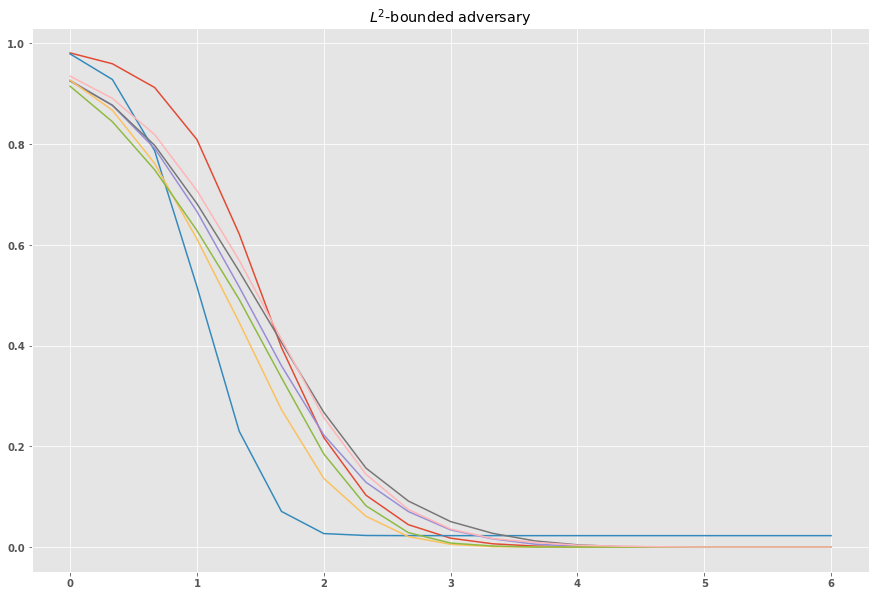

<Figure size 1008x504 with 0 Axes>

In [39]:
with plt.style.context('ggplot'):
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.labelweight"] = "bold"
    plt.rcParams["axes.labelcolor"] = "black"
    fig, axes = plt.subplots(1, 1, figsize=(15,10))
    plt.figure(figsize=(14,7))
    axes.set_title('$L^2$-bounded adversary')
    axes.plot(pgd_attack_range, acc_SGD, label='SGD')
    axes.plot(pgd_attack_range, acc_ESGD, label='Entropy-SGD')
    axes.plot(pgd_attack_range, acc_SAT2, label='Data-Entropy-SGD ($L_2$)')
    axes.plot(pgd_attack_range, acc_SATInf, label='Data-Entropy-SGD ($L_\infty$)')
    axes.plot(pgd_attack_range, acc_l2, label='$L2$ training')
    axes.plot(pgd_attack_range, acc_linf, label='$L{\infty}$ training')
    axes.plot(pgd_attack_range, acc_TRADES, label='TRADES training')
    axes.vlines([3], 0, 1, colors=COLOURS[1], linestyle='--')
    axes.set_ylabel('Accuracy')
    axes.set_xlabel('Epsilon')
    axes.set_ylim((0,1))
    axes.legend(['sgd'])

In [ ]:
loadResultsFGSM = False

In [ ]:
t1 = time.time()
if not loadResultsFGSM:
    fgsm_attack_range = np.arange(0.0, 0.52, 0.025)
    fgsm_acc_linf = []
    fgsm_acc_l2 = []
    fgsm_acc_SGD = []
    fgsm_acc_ESGD = []
    fgsm_acc_SAT2 = []
    fgsm_acc_SATInf = []
    for eps in fgsm_attack_range:
        print('eps:',eps)
        print('evaluating SGD network...')
        fgsm_acc_SGD.append(evaluate_against_adversary(model_SGD, k=20, eps=eps, step=0.1, norm='inf'))
        print('evaluating ESGD network...')
        fgsm_acc_ESGD.append(evaluate_against_adversary(model_ESGD, k=20, eps=eps, step=0.1, norm='inf'))
        print('evaluating SAT2 network...')
        fgsm_acc_SAT2.append(evaluate_against_adversary(model_SAT2, k=10, eps=eps, step=0.1, norm='inf'))
        print('evaluating SATInf network...')
        fgsm_acc_SATInf.append(evaluate_against_adversary(model_SATInf, k=10, eps=eps, step=0.1, norm='inf'))        
        print('evaluating linf network...')
        fgsm_acc_linf.append(evaluate_against_adversary(adv_model_linf, k=50, eps=eps, step=0.02, norm='inf'))
        print('evaluating l2 network...')
        fgsm_acc_l2.append(evaluate_against_adversary(adv_model_l2, k=50, eps=eps, step=0.02, norm='inf'))
    
print("time elapsed:",time.time()-t1)    

In [ ]:
if not loadResultsFGSM:    
    fgsmaccData = [fgsm_acc_SGD,fgsm_acc_ESGD,fgsm_acc_l2,fgsm_acc_linf,fgsm_acc_SAT2,fgsm_acc_SATInf]
    np.save('../results/fgsmaccData.npy',fgsmaccData)

In [ ]:
if loadResultsFGSM:
    fgsm_attack_range = np.arange(0.0, 0.52, 0.025)
    accData2 = np.load('../results/fgsmaccData.npy')
    [fgsm_acc_SGD,fgsm_acc_ESGD,fgsm_acc_l2,fgsm_acc_linf,fgsm_acc_SAT2,fgsm_acc_SATInf] = accData2

In [ ]:
with plt.style.context('ggplot'):
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.labelweight"] = "bold"
    plt.rcParams["axes.labelcolor"] = "black"
    fig, axes = plt.subplots(1, 1, figsize=(15,10))
    plt.figure(figsize=(14,7))
    axes.set_title('$L^\infty$-bounded adversary')
    axes.plot(fgsm_attack_range, fgsm_acc_SGD, label='SGD')
    axes.plot(fgsm_attack_range, fgsm_acc_ESGD, label='Entropy-SGD')
    axes.plot(fgsm_attack_range, fgsm_acc_SAT2, label='Data-Entropy-SGD ($L_2$)')
    axes.plot(fgsm_attack_range, fgsm_acc_SATInf, label='Data-Entropy-SGD ($L_\infty$)')    
    axes.plot(fgsm_attack_range, fgsm_acc_l2, label='$L2$ training')
    axes.plot(fgsm_attack_range, fgsm_acc_linf, label='$L{\infty}$ training')
    axes.vlines([0.25], 0, 1, colors=COLOURS[1], linestyle='--')
    axes.set_ylabel('Accuracy')
    axes.set_xlabel('Epsilon')
    axes.set_ylim((0,1))
    axes.legend()